# Big Hit prediction for video games

Based on data from 1996-2016, we tried to predict the genre of the big hit in the following year. 

## Hypothesis
_It is possible to predict the genre of the next big hit with significant accuracy based on statistical analysis for each of the following platforms: Xbox, Playstation, Nintendo and PC._

In [1]:
import csv             
import numpy as np
import matplotlib.pyplot as plt       
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from scipy.stats.stats import pearsonr

key_title = 'title'
key_platform = 'platform'
key_score = 'score'
key_release_y = 'release_year'
key_release_m = 'release_month'
key_release_d = 'release_day'
key_release_q = 'release_quarter'

key_rank = 'Rank'
key_genre = 'Genre'
key_publisher = 'Publisher'
key_NA = 'NA_Sales'
key_EU = 'EU_Sales'
key_JP = 'JP_Sales'
key_other = 'Other_Sales'
key_global = 'Global_Sales'
key_const = 'constant_one'

keys = [key_title, key_platform, key_score, key_release_y, key_release_m, key_release_d, key_release_q,\
        key_rank, key_genre, key_publisher, key_NA, key_EU, key_JP, key_other, key_global, key_const]

def beautify_dict(data):
    for i in range(0, len(data)):
        data[i][key_score] = float(data[i][key_score])
        data[i][key_rank] = int(data[i][key_rank])
        data[i][key_release_y] = int(data[i][key_release_y])
        data[i][key_release_m] = int(data[i][key_release_m])
        data[i][key_release_d] = int(data[i][key_release_d])
        data[i][key_release_q] = ['Q1', 'Q2', 'Q3', 'Q4'][(data[i][key_release_m] - 1) // 3]
        data[i][key_NA] = float(data[i][key_NA])
        data[i][key_EU] = float(data[i][key_EU])
        data[i][key_JP] = float(data[i][key_JP])
        data[i][key_other] = float(data[i][key_other])
        data[i][key_global] = float(data[i][key_global])
        data[i][key_const] = 1

def get_beautiful_dict(file_name):    
    fin = open(file_name, 'r')
    file_data = csv.DictReader(fin)

    data = [row for row in file_data]      
    beautify_dict(data)
    return data

def get_all_from_data(key, data):
    return [row[key] for row in data]

def get_unique_from_data(key, data):
    return list(set(get_all_from_data(key, data)))

def calc_r(data_set1, data_set2):
    r, p = pearsonr(data_set1, data_set2)
    return r

def calc_r_key(key1, key2, data):
    return calc_r(get_all_from_data(key1, data), get_all_from_data(key2, data))

def split_categorical_key(key, data):
    res_data = [dict() for row in data]
    
    categories = get_unique_from_data(key, data)
    
    for i, row in enumerate(res_data):
        for cat in categories:
            if cat == data[i][key]:
                row[cat] = 1
            else:
                 row[cat] = 0
    
    return categories, res_data

def from_lod_to_dol(data):
    res = dict()
    for key in data[0]:
        res[key] = [data[0][key]]
        
    for i in range(1, len(data)):
        for key in data[i]:
            res[key].append(data[i][key])
            
    return res


data = get_beautiful_dict('data/our_data.csv')
data_xbox = get_beautiful_dict('data/our_data_Xbox.csv')
data_playstation = get_beautiful_dict('data/our_data_PlayStation.csv')
data_nintendo = get_beautiful_dict('data/our_data_Nintendo.csv')
data_pc = get_beautiful_dict('data/our_data_PC.csv')

/home/xavier/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## The data
We combined two datasets from Kaggle.com, which were [Sales data](https://www.kaggle.com/gregorut/videogamesales) and [Review data](https://www.kaggle.com/egrinstein/20-years-of-games). When these two were combined, we had 7003 games spread out over the years 1996 - 2016. See the following graph for this distribution for the 4 major platforms.

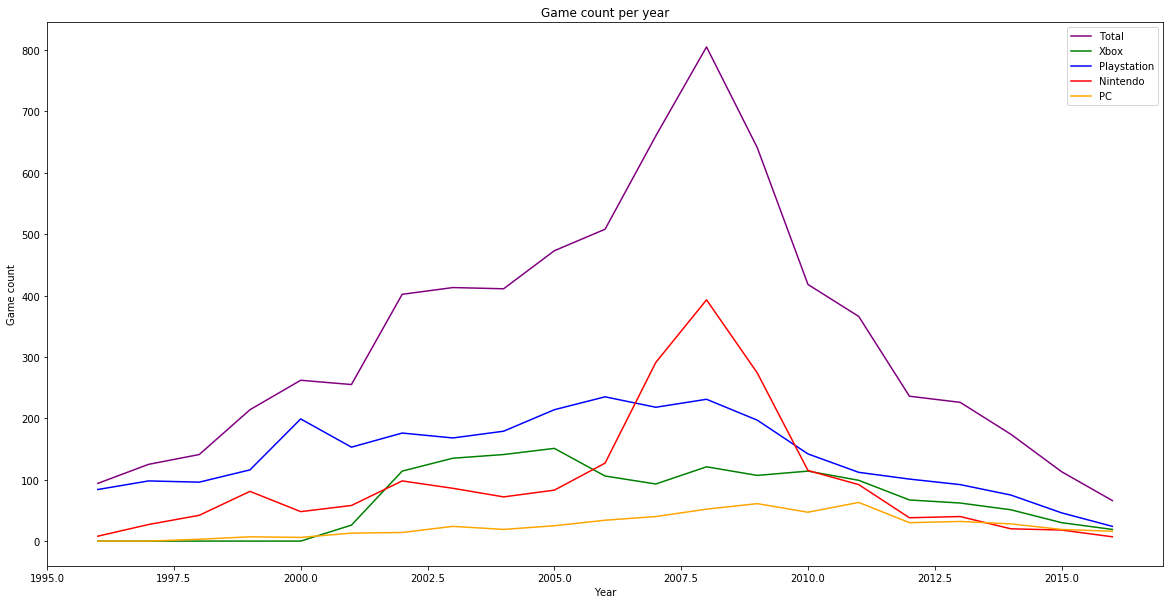

In [2]:

def plot_count_per_year(data, l, color):
    years = get_unique_from_data(key_release_y, data)
    count_per_year = [0 for y in range(1996, 2017)]
    for row in data:
        count_per_year[int(row[key_release_y]) - 1996] += 1

    plt.plot(range(1996, 2017), count_per_year, label=l, color=color)

plt.figure(figsize=(20, 10))
plot_count_per_year(data, 'Total', color='purple')
plot_count_per_year(data_xbox, 'Xbox', color='green')
plot_count_per_year(data_playstation, 'Playstation', color='blue')
plot_count_per_year(data_nintendo, 'Nintendo', color='red')
plot_count_per_year(data_pc, 'PC', color='orange')
plt.xlabel('Year')
plt.ylabel('Game count')
plt.title('Game count per year')
plt.legend()
plt.show()

### Different platforms favor different genres, as shown below
After looking more into the structure of the genres we found out that PC favors strategy games, but those are functually non-existend on other platforms. The Miscellaneous genre is quite big on the Nintendo platform.This information can be found in the following plots below.

It happens that there are some significant differences between the popularities of genres per platform as shown in the game count per genre bar charts below. Due to this behaviour we have chosen to split up our data into 4 different catogories for each platform section. We have divided the dataset in a Nintendo dataset, containing all the games made for a Nintendo branch console and using the same concept to split the data further in a PlayStation, Xbox and PC datasets.  

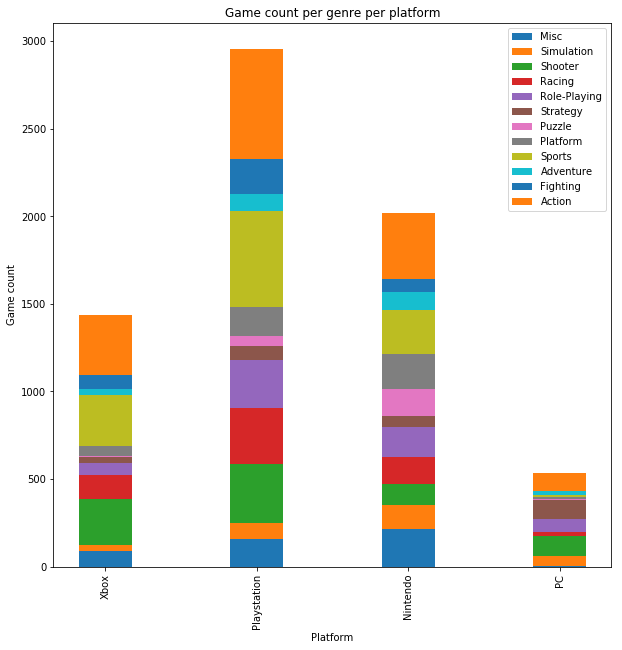

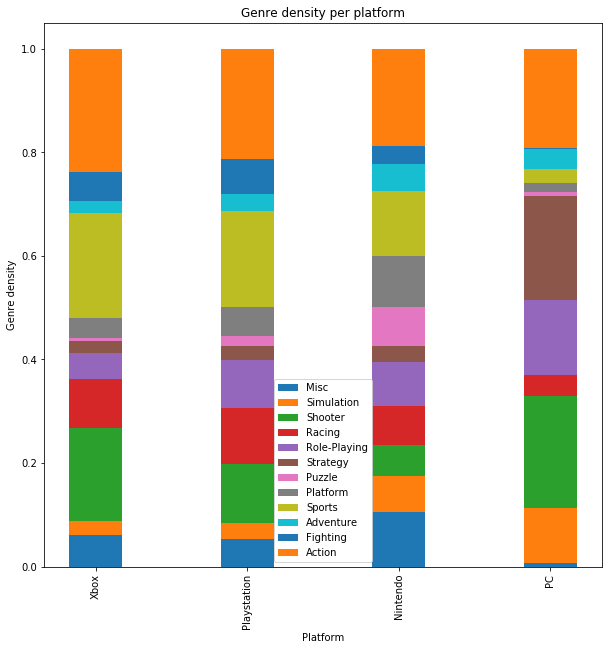

In [3]:
genres = get_unique_from_data(key_genre, data)

count_per_platform_per_genre = [[0 for _ in range(4)] for g in genres]
for i, g in enumerate(genres):
    for row in data_xbox:
        if row[key_genre] == g:
            count_per_platform_per_genre[i][0] += 1
    
    for row in data_playstation:
        if row[key_genre] == g:
            count_per_platform_per_genre[i][1] += 1            
    
    for row in data_nintendo:
        if row[key_genre] == g:
            count_per_platform_per_genre[i][2] += 1            
    
    for row in data_pc :
        if row[key_genre] == g:
            count_per_platform_per_genre[i][3] += 1
plots = []
plt.figure(figsize=(10, 10))

sum_so_far = [0 for _ in range(4)]
for i, genre in enumerate(genres):
    plots.append(plt.bar(range(4), count_per_platform_per_genre[i], 0.35, bottom = sum_so_far))
    sum_so_far = [s + count_per_platform_per_genre[i][j] for j, s in enumerate(sum_so_far)]

plt.ylabel('Game count')
plt.xlabel('Platform')
plt.title('Game count per genre per platform')
plt.xticks(range(4), ["Xbox", "Playstation", "Nintendo", "PC"], rotation='vertical')
plt.legend([p[0] for p in plots], genres)
plt.show()

# normalized version
plots = []
plt.figure(figsize=(10, 10))

total = [0 for _ in range(4)]
for i, genre in enumerate(genres):
    total = [s + count_per_platform_per_genre[i][j] for j, s in enumerate(total)]
    

sum_so_far = [0 for _ in range(4)]
for i, genre in enumerate(genres):
    plots.append(plt.bar(range(4), [c / total[j] for j, c in enumerate(count_per_platform_per_genre[i])] , 0.35, bottom = sum_so_far))
    sum_so_far = [s + count_per_platform_per_genre[i][j] / total[j] for j, s in enumerate(sum_so_far)]

plt.ylabel('Genre density')
plt.xlabel('Platform')
plt.title('Genre density per platform')
plt.xticks(range(4), ["Xbox", "Playstation", "Nintendo", "PC"], rotation='vertical')
plt.legend([p[0] for p in plots], genres)
plt.show()

### The genres of the big hit per platform per quarter per year
Now we will extract the "Big Hits" genres for each platform section for each quarter of the year.
A year will be divided into four quarters where each quarter will indicate a time period of three months.

In [4]:

def find_max_saled_game_in_dict_with_key(dictio, key):
    max_val = 0.0
    max_row = None
    for row in dictio:
        if row[key] > max_val:
            max_val = float(row[key])
            max_row = row
    if max_row == None:
        max_row = {key_title: '---------', key_genre: '--', key_global: 0}
    return max_row

def get_big_hits_in_year(year, data, key):
    quarter1 = []
    quarter2 = []
    quarter3 = []
    quarter4 = []
    the_hit = []
    for row in data:
        if row[key_release_y] == year:
            if row[key_release_q] is 'Q1':
                quarter1.append(row)
            elif row[key_release_q] is 'Q2':
                quarter2.append(row)
            elif row[key_release_q] is 'Q3':
                quarter3.append(row)
            elif row[key_release_q] is 'Q4':
                quarter4.append(row)

    max1 = find_max_saled_game_in_dict_with_key(quarter1, key)
    max2 = find_max_saled_game_in_dict_with_key(quarter2, key)
    max3 = find_max_saled_game_in_dict_with_key(quarter3, key)
    max4 = find_max_saled_game_in_dict_with_key(quarter4, key)
    hit = find_max_saled_game_in_dict_with_key([max1, max2, max3, max4], key)
    
    return max1, max2, max3, max4, hit

def get_big_hits(data, key):
    big_hits = []
    for y in range(min_year, max_year):
        big_hits.append(get_big_hits_in_year(y, data, key))
        
    return big_hits

min_year = 2000
max_year = 2017

big_hits_xbox = get_big_hits(data_xbox, key_global)
big_hits_playstation = get_big_hits(data_playstation, key_global)
big_hits_nintendo = get_big_hits(data_nintendo, key_global)
big_hits_pc = get_big_hits(data_pc, key_global)
big_hits = get_big_hits(data, key_global)

print('Quarter : {:15} : {:15} : {:15} : {:15} : {:15}'.format('Xbox', 'Playstation', 'Nintendo', 'PC', 'All'))
print('--------:-----------------:-----------------:-----------------:-----------------:----------------')
for i in range(max_year - min_year):
    #print(y, ': ', big_hits[i][4][key_genre], ': ', big_hits[i][4][key_title])
    
    for q in range(4):
        print(q + 1, '      : ', 
              '{:15}: '.format(big_hits_xbox[i][q][key_genre]),
              '{:15}: '.format(big_hits_playstation[i][q][key_genre]), 
              '{:15}: '.format(big_hits_nintendo[i][q][key_genre]), 
              '{:15}: '.format(big_hits_pc[i][q][key_genre]), 
              '{:15}'.format(big_hits[i][q][key_genre]), )
    print('All     : ', 
          '{:15}: '.format(big_hits_xbox[i][q][key_genre]),
          '{:15}: '.format(big_hits_playstation[i][q][key_genre]), 
          '{:15}: '.format(big_hits_nintendo[i][q][key_genre]), 
          '{:15}: '.format(big_hits_pc[i][q][key_genre]), 
          '{:15}'.format(big_hits[i][q][key_genre]), )
        

Quarter : Xbox            : Playstation     : Nintendo        : PC              : All            
--------:-----------------:-----------------:-----------------:-----------------:----------------
1       :  --             :  Shooter        :  Strategy       :  Simulation     :  Strategy       
2       :  --             :  Role-Playing   :  Action         :  Strategy       :  Action         
3       :  --             :  Sports         :  Sports         :  Role-Playing   :  Sports         
4       :  --             :  Role-Playing   :  Action         :  Strategy       :  Role-Playing   
All     :  --             :  Role-Playing   :  Action         :  Strategy       :  Role-Playing   
1       :  --             :  Action         :  Role-Playing   :  Simulation     :  Action         
2       :  --             :  Sports         :  Platform       :  Simulation     :  Platform       
3       :  --             :  Sports         :  Puzzle         :  Role-Playing   :  Sports         
4       :  S

### Heatmap of the similarity between platforms using mean sales per genre

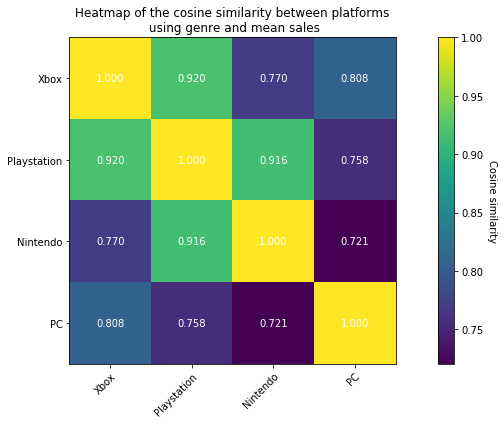

In [5]:
# define the functions needed to calculate the cosine similarity
def magnitude(v):
    sqr_mag = 0
    for val in v:
        sqr_mag += val * val
    return sqr_mag ** (1/2)

def normalized(v):
    mag = magnitude(v)
    return [val / mag for val in v]

def dot(v1, v2):
    d = 0
    for i in range(len(v1)):
        d += v1[i] * v2[i]
    return d
    
def cos_sim(v1, v2):
    norm_v1 = normalized(v1)
    norm_v2 = normalized(v2)
    return dot(norm_v1, norm_v2)

def mean(v):
    return sum(v)/len(v)

def lerp(a, b, v):
    #return (b - a) * v + a #this is faster but not numerically stable with a large difference between a and b
    return a * (1 - v) + b * v

def percentile(values, alpha):
    if len(values) == 0:
        return 0
    if len(values) == 1:
        return values[0]
    
    s = sorted(values)
    l = len(values) - 1
    
    idx_start = int(l * alpha)
    idx_end = idx_start + 1
    
    a = s[idx_start]
    b = s[idx_end]
    
    # linearly interpolate between the two values
    p_start = idx_start / l
    p_end = idx_end / l
    return lerp(a, b, (alpha - p_start) / (p_end - p_start))

# get the median of the value per categorie
def get_cat_mean_val(key_cat, key_val, data):
    # get the unique categories and create a dict with an empty list for each categorie
    categories = get_unique_from_data(key_cat, data)
    d = {}
    for cat in categories:
        d[cat] = []
        
    # store all values from the data set in the dictionary
    for row in data:
        d[row[key_cat]].append(row[key_val])
        
    # return a list of means
    return [mean(d[cat]) for cat in categories]

def show_cos_sim_heatmap(dic, bar_label, title):    
    labels = [key for key in dic]

    values = [[1.0 for key in dic] for key in dic]
    for i, key_i in enumerate(dic):
        for j, key_j in enumerate(dic):
            if i is not j:
                values[i][j] = cos_sim(dic[key_i], dic[key_j])


    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(values)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, "{:.3f}".format(values[i][j]),
                       ha="center", va="center", color="w")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(bar_label, rotation=-90, va="bottom")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()


# get the data
genres, genre_data = split_categorical_key(key_genre, data)
quarters, quarter_data = split_categorical_key(key_release_q, data)

genres = get_unique_from_data(key_genre, data)
quarters = get_unique_from_data(key_release_q, data)

# heatmap genre sales
genre_sales_dict = {
    "Xbox":get_cat_mean_val(key_genre, key_global, data_xbox),
    "Playstation":get_cat_mean_val(key_genre, key_global, data_playstation),
    "Nintendo":get_cat_mean_val(key_genre, key_global, data_nintendo),
    "PC":get_cat_mean_val(key_genre, key_global, data_pc)
}
show_cos_sim_heatmap(genre_sales_dict, "Cosine similarity", "Heatmap of the cosine similarity between platforms\n using genre and mean sales")


As can be sees, the biggest similarity difference is between Xbox and PC. This is a surprise, since both are owned by microsoft (gaming on MacOS and Linux are ignored here because most games are played on Windows PCs). Xbox and Playstation, and Playstation and Nintendo are quite similar.

## Analysis

In order to predict to what genre the biggest hit will belong, we need to set up some models which we can use to predict the future.

### Projected growth of genre sales
Here are five plots showing the past growth of genres, and the predicted growth up to 2018. We made the line fade away if the fitted model had a low adjusted $r^2$, so if you have to squint to see it, it probably isn't worth seeing.

The dominance of the shooter genre is obvious. It is pretty visible compared to the other lines so it one of the most secure fits, and it rises above all other genres for all platforms but Nintendo. There, the platform genre is the best selling one.

Xbox:


/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


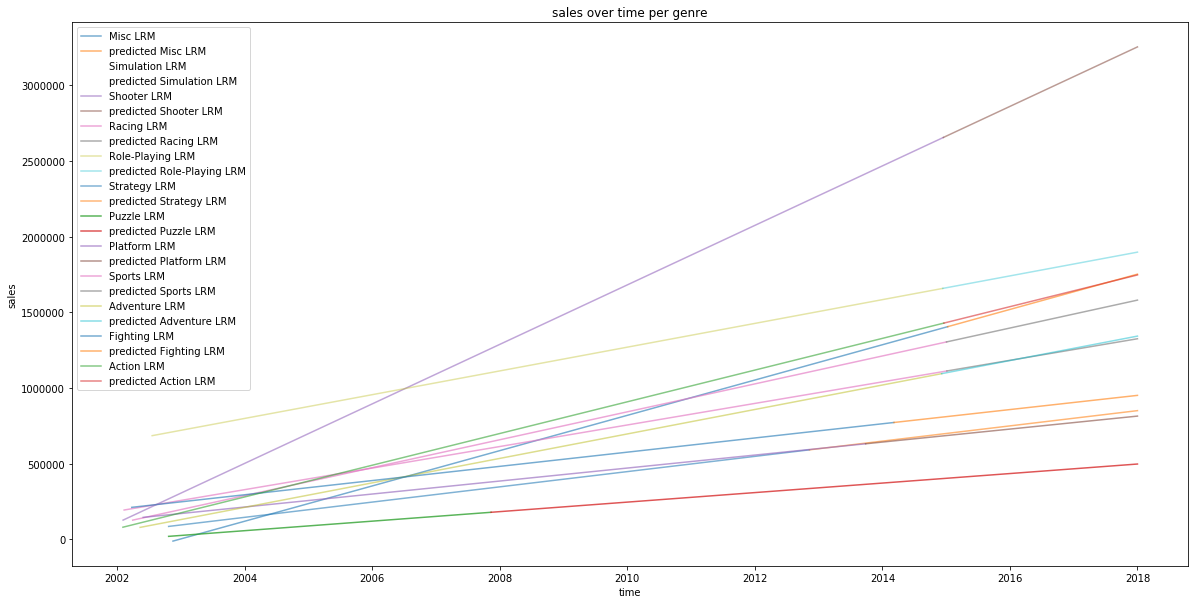

playstation:


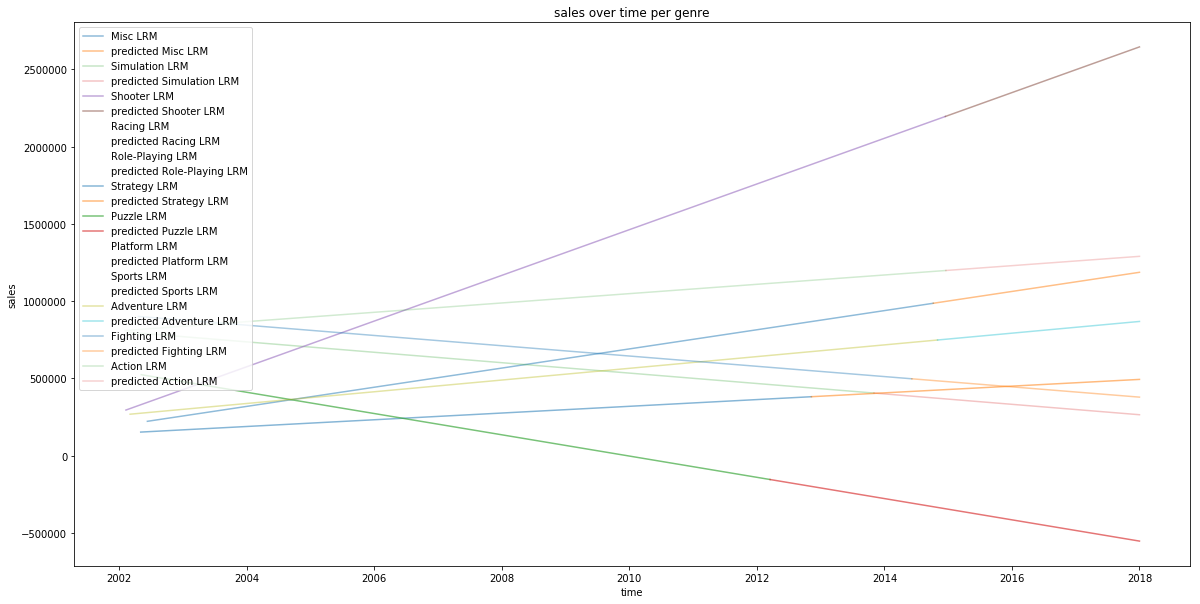

Nintendo:


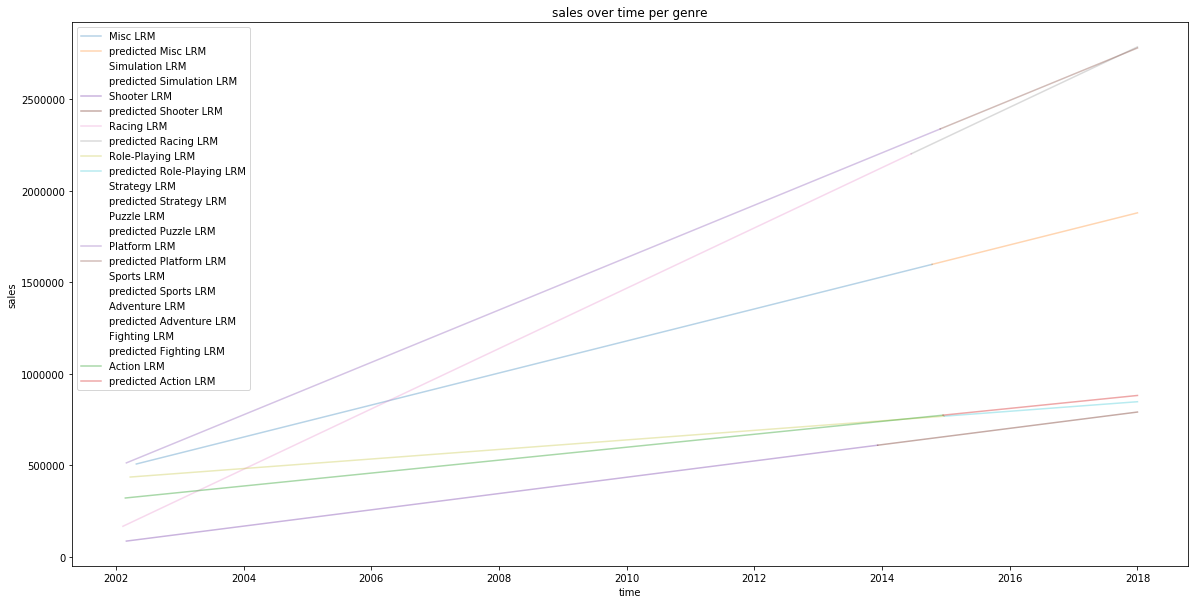

PC:


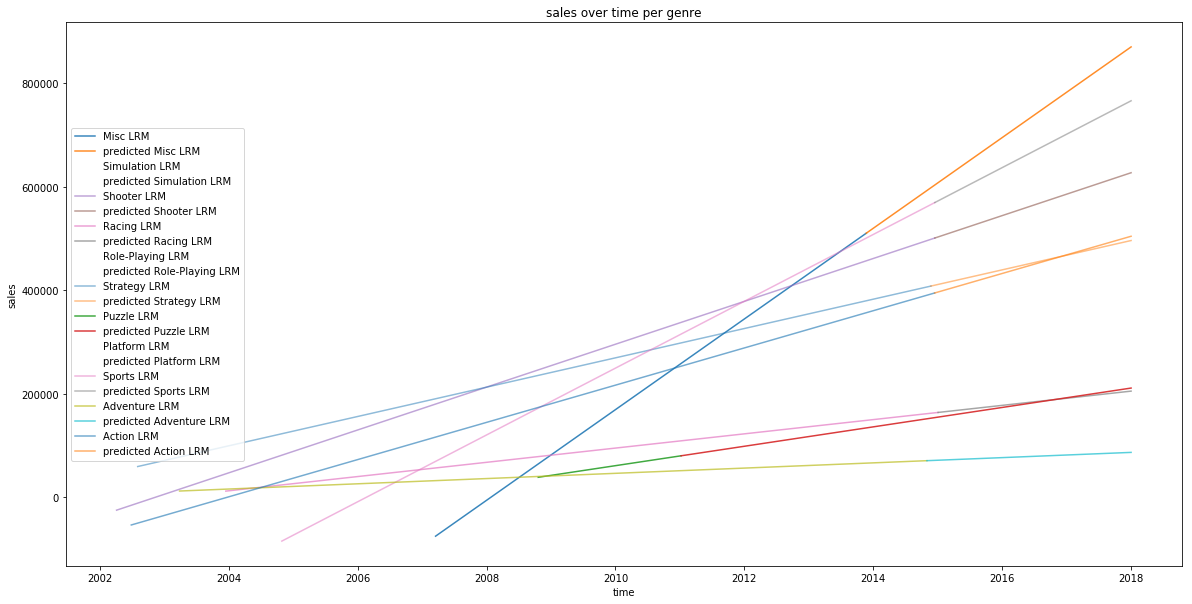

All:


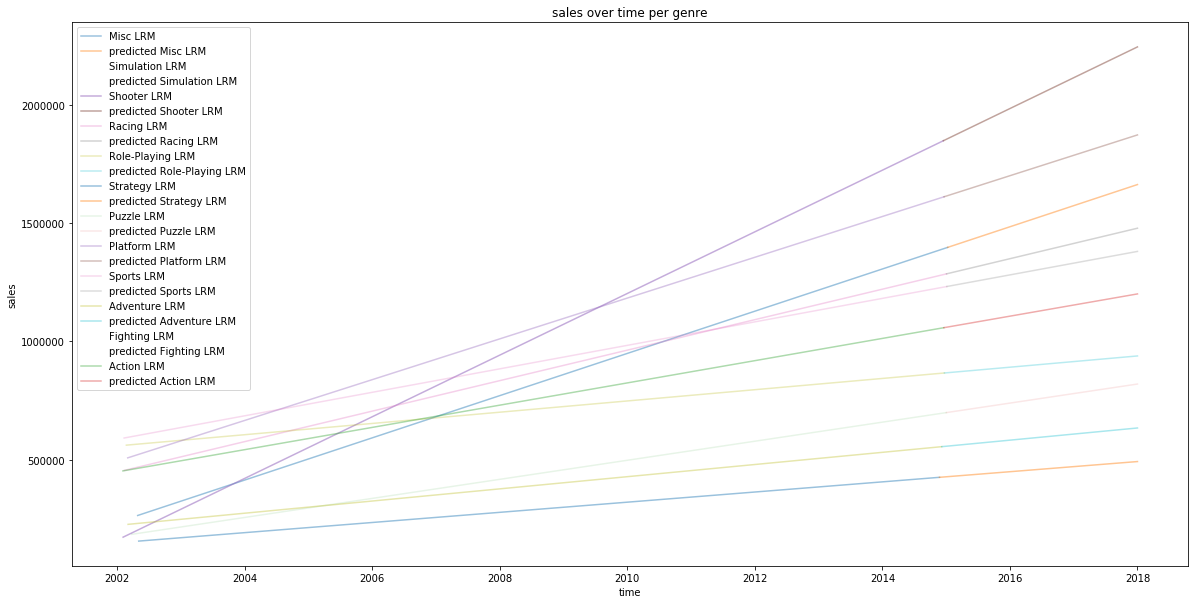

In [6]:
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
genres = get_unique_from_data(key_genre, data)

def get_continuous_year(game):
    y = int(game[key_release_y])
    m = int(game[key_release_m])
    d = int(game[key_release_d])
    return y + m / 12 + (d / 12) / days_per_month[m - 1]

def plot_sales_over_time_for_genre(genre, data, year_min = 2002, year_max = 2014, year_predict = 2018, plot_points = False, alpha_exp = 0.2):
    dates = []
    min_date = 9999
    max_date = 0
    sales = []
    for row in data:
        if row[key_genre] == genre:
            year = int(row[key_release_y])
            if year <= year_max and year >= year_min:
                date = get_continuous_year(row)
                dates.append(date)
                sales.append(row[key_global] * 1000000)

                if min_date > date:
                    min_date = date
                if max_date < date:
                    max_date = date            
    
    if(len(sales) < 2):
        return
    else:
        results = sm.OLS(sales, sm.add_constant(dates)).fit()
        x_line = np.linspace(min_date, max_date, 100)
        y_line = [x * results.params[1] + results.params[0] for x in x_line]
        x_predict = np.linspace(max_date, year_predict, 100)
        y_predict = [x * results.params[1] + results.params[0] for x in x_predict]
        if plot_points:
            plt.scatter(dates, sales, label = genre)
        plt.plot(x_line, y_line, label = genre + ' LRM', alpha = results.rsquared_adj ** alpha_exp)  
        plt.plot(x_predict, y_predict, label = 'predicted ' + genre + ' LRM', alpha = results.rsquared_adj ** alpha_exp)    
    
def show_sales_over_time_per_genre(data, year_min = 2002, year_max = 2014, year_predict = 2018, plot_points = False):
    plt.figure(figsize=(20, 10))
    for g in genres:
        plot_sales_over_time_for_genre(g, data, year_min, year_max, year_predict, plot_points)
    plt.xlabel('time')
    plt.ylabel('sales')
    plt.title('sales over time per genre')
    plt.legend()
    plt.show()

print('Xbox:')
show_sales_over_time_per_genre(data_xbox)
print('playstation:')
show_sales_over_time_per_genre(data_playstation)
print('Nintendo:')
show_sales_over_time_per_genre(data_nintendo)
print('PC:')
show_sales_over_time_per_genre(data_pc)
print('All:')
show_sales_over_time_per_genre(data)

This method turned out to be very unreliable. The adjusted $r^2$ was low for almost every line, and we had to take the 5th root to get a readable result. So, we moved on to the next technique.

### Multi-linear regression model using genre and score
To figure out if it is possible to even use such a model, we needed to make sure that both genre and score were correlated with sales.

#### Correlation analysis between score and sales
First up was checking to see if there was a correlation between score and sales. Outliers (looking at you, Wii Sports) can make the LRM a bit unreadable so we transformed the sales data with a logarithm to make everything lie closer together, then fitted the LRM and then transformed both of them back. We plotted this on a log scale plot on the y axis, which still results into a straight line.

All results show a clear rising line, so we went ahead with adding score to our model.

Using all the data of every platform:


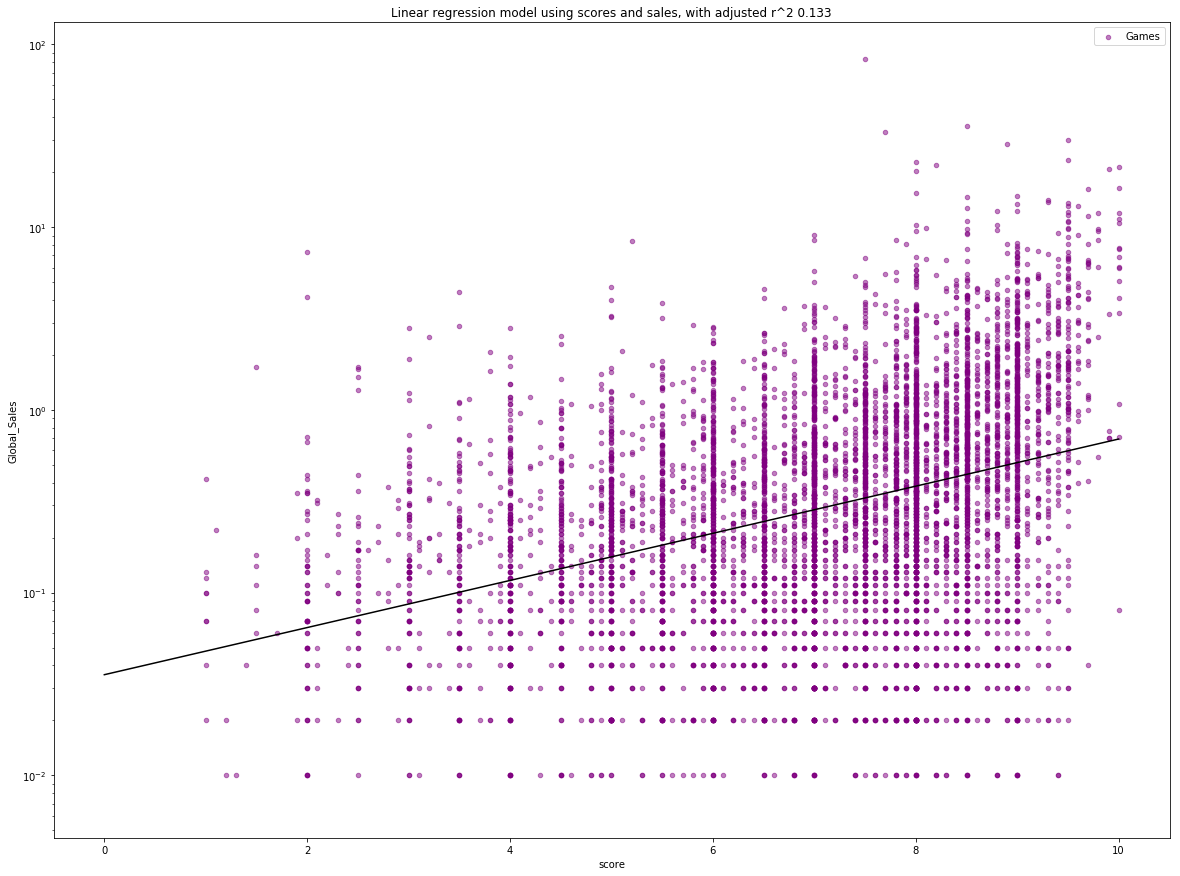

Using Xbox data:


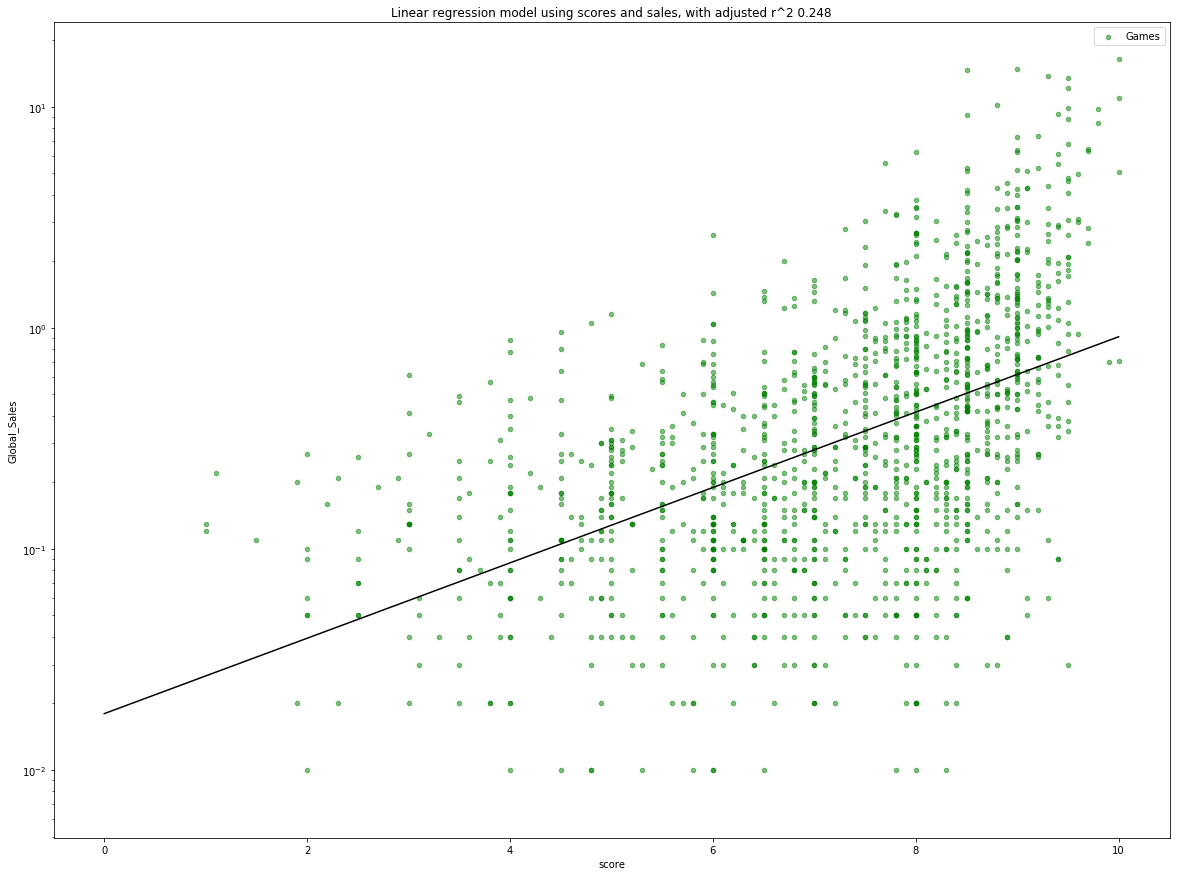

Using Playstation data:


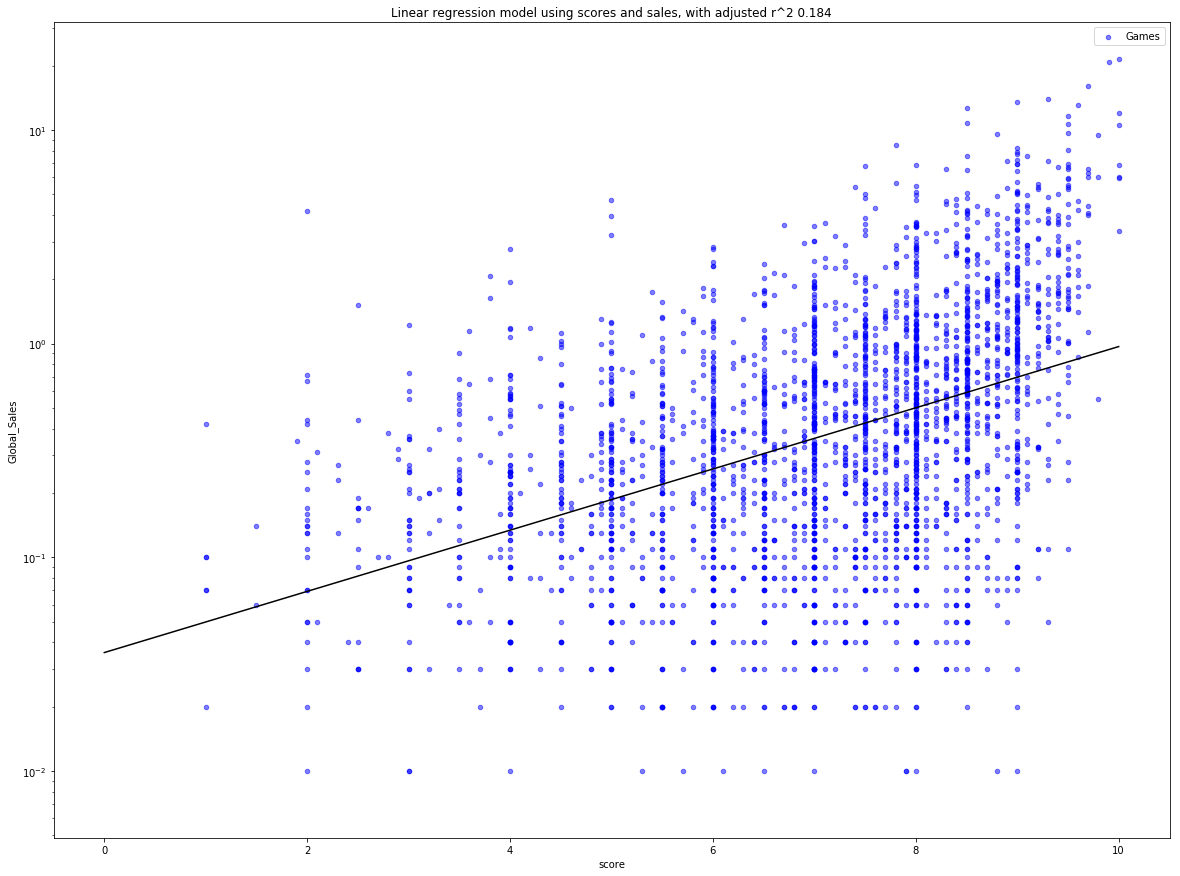

Using Nintendo data:


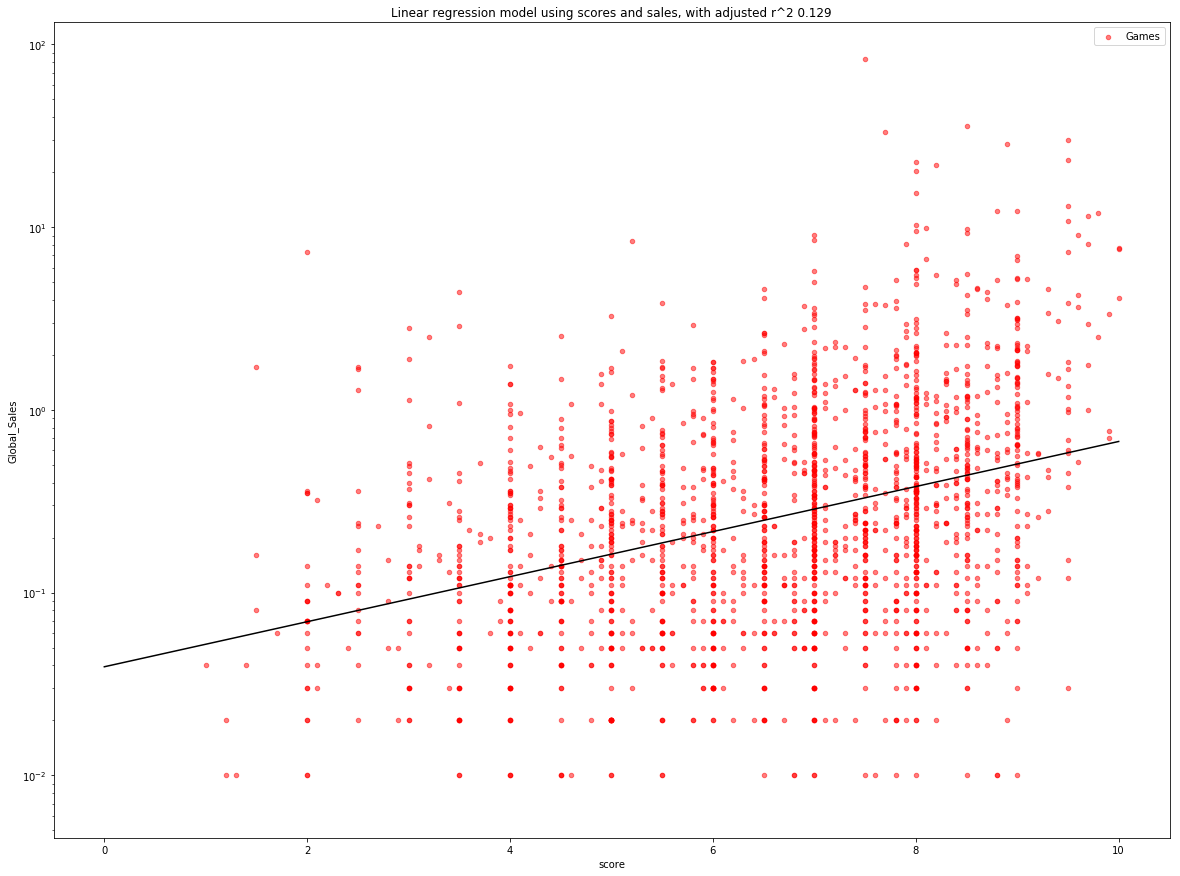

Using PC data:


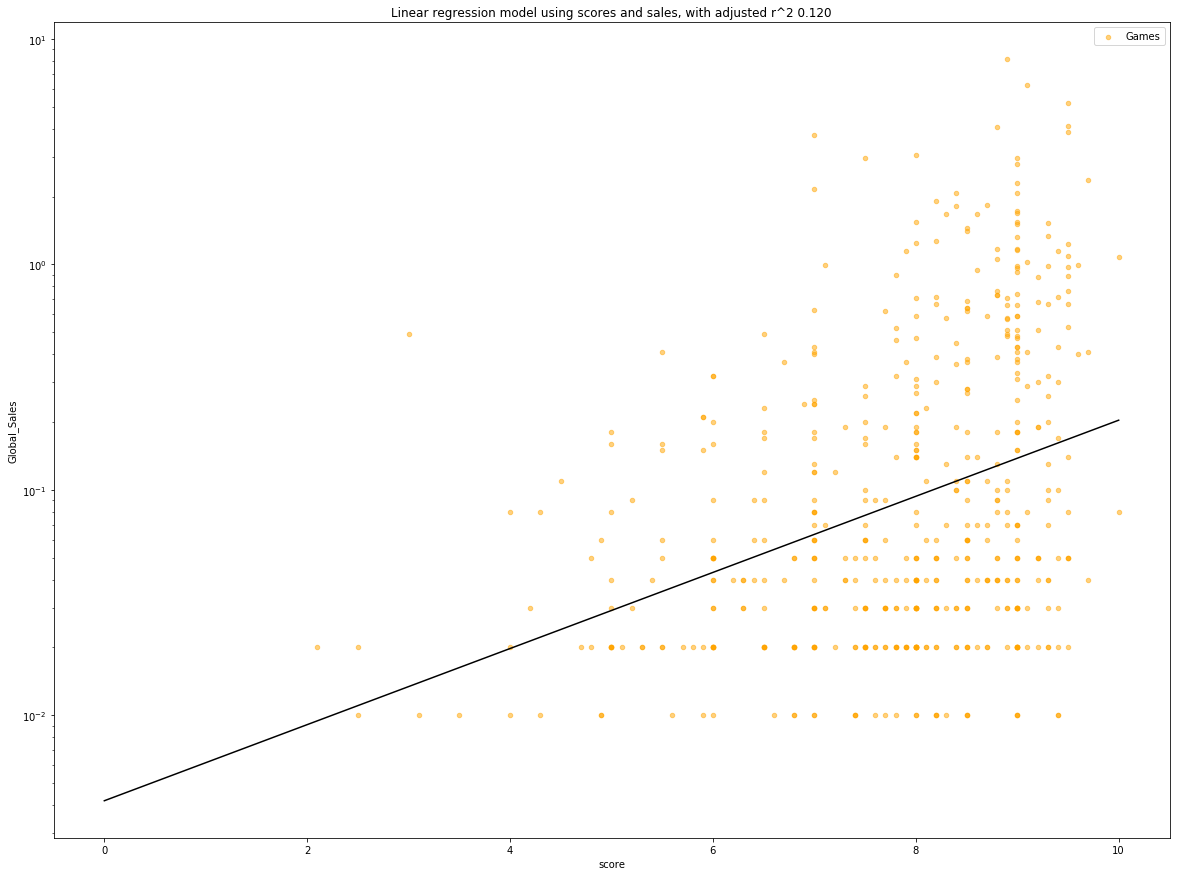

In [7]:
def plot_linr(data, key_target, key_param, use_log_scale = True, color_scatter = 'blue', color_line = 'black'):
    data = [dict(row) for row in data]
    data2 = [dict(row) for row in data]
    
    # transform our data
    for i in range(0, len(data)):
        data2[i][key_target] = np.log(data2[i][key_target] * 10**6)
    
    target_values = get_all_from_data(key_target, data2)
    
    df1 = pd.DataFrame(data, columns=keys)
    df2 = pd.DataFrame(data2, columns=keys)
    
    # Put the target (Global Sales -- Global_Sales) in another DataFrame
    target2 = pd.DataFrame(target_values, columns=[key_target])
    
    X2 = df1[key_param]
    y2 = target2[key_target]
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(y2, X2)

    ax = df1.plot(x=key_param, y=key_target, kind='scatter', label='Games', alpha=0.5, figsize=(20,15), color=color_scatter)
    mp = model2.fit().params
    
    # generate x-values for your regression line (two is sufficient)
    x = np.arange(0, 10.1, 0.1)

    # plot regression line on the same axes, set x-axis limits
    ax.plot(x, np.e**(mp.const + mp.score * x) / 10**6, color=color_line, label='LRM for only param Score')
    
    if use_log_scale:
        plt.yscale('log')
        
    plt.title('Linear regression model using scores and sales, with adjusted r^2 {:.3f}'.format(model2.fit().rsquared_adj))
    plt.show()
    
print('Using all the data of every platform:')
plot_linr(data, key_global, key_score, True, 'purple')
print('Using Xbox data:')
plot_linr(data_xbox, key_global, key_score, True, 'green')
print('Using Playstation data:')
plot_linr(data_playstation, key_global, key_score, True, 'blue')
print('Using Nintendo data:')
plot_linr(data_nintendo, key_global, key_score, True, 'red')
print('Using PC data:')
plot_linr(data_pc, key_global, key_score, True, 'orange')

#### Correlation analysis between Sales and Genre
Next up was an analysis of the correlation between sales and genre. In the box plots below, you can see that there is a big difference between the genres, for each platform individually and also for all platforms combined. We already knew this because of the genre-sales time series above, but this sums it all up.

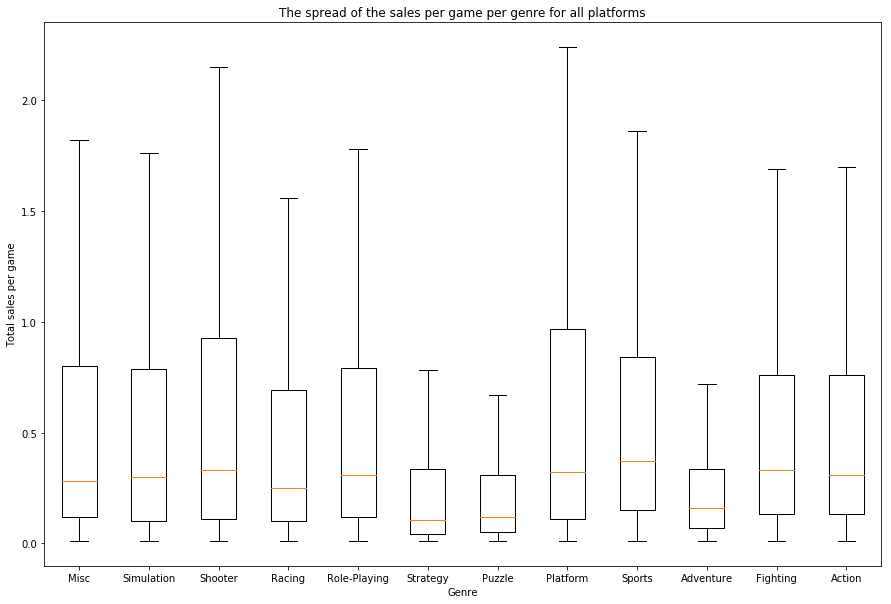

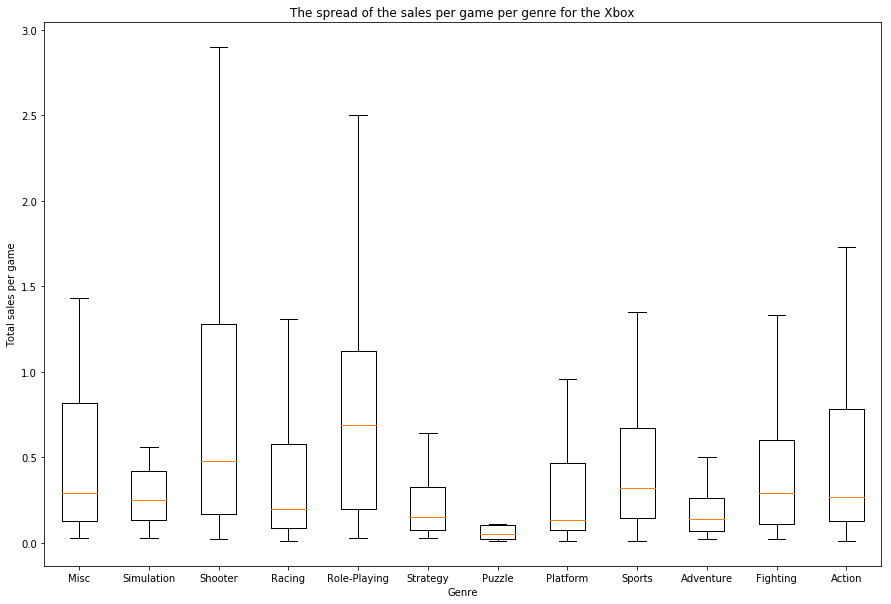

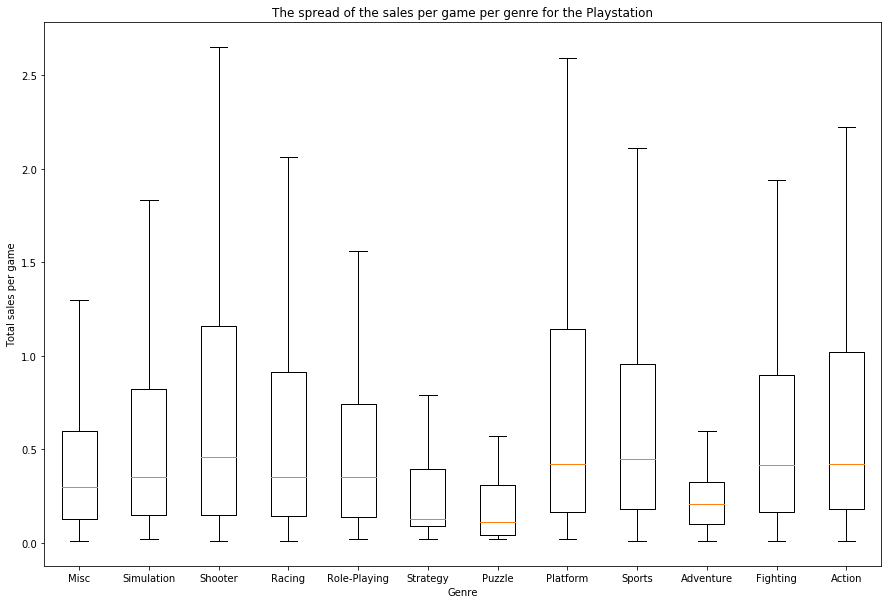

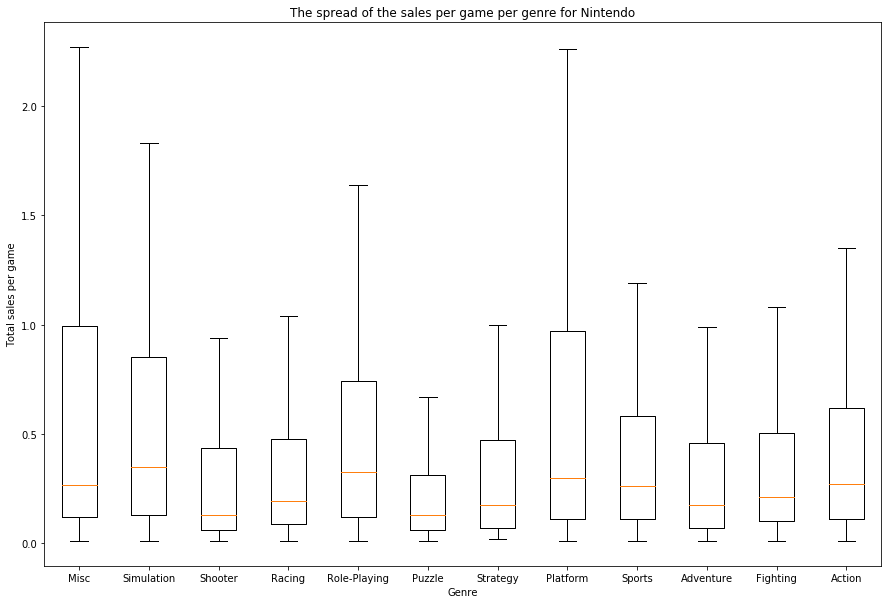

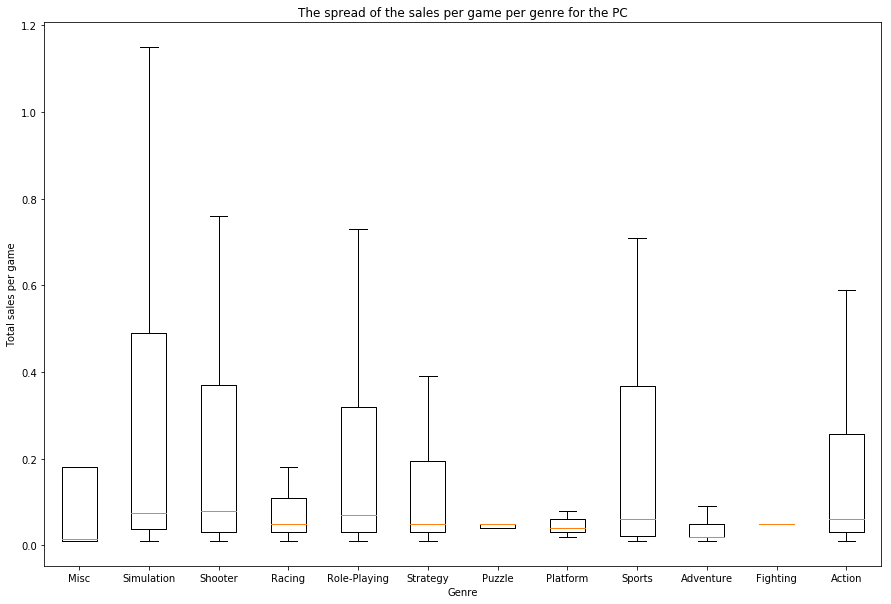

In [8]:
def plot_box_plot(categorie_data, categories, value_data, xlabel, ylabel, title):
    # box plot of sales per quarter
    value_per_categorie = [[] for _ in range(len(categories))]
    for i, value in enumerate(value_data):
        for j, categorie in enumerate(categories):
            if categorie_data[categorie][i] == 1:
                value_per_categorie[j].append(value)

    plt.figure(figsize=(15, 10))
    plt.boxplot(value_per_categorie, 0, '')
    plt.xticks(range(1, len(categories) + 1), categories)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.show()
    
    
# numerical data
sales = get_all_from_data(key_global, data)
scores = get_all_from_data(key_score, data)

# categorical data
genres, genre_data = split_categorical_key(key_genre, data)
genre_data = from_lod_to_dol(genre_data)

# now call plot_box_plot to plot the box plot
plot_box_plot(genre_data, genres, sales, 'Total sales per game', 'Genre', 'The spread of the sales per game per genre for all platforms')


# numerical data
sales_xbox = get_all_from_data(key_global, data_xbox)
scores_xbox = get_all_from_data(key_score, data_xbox)

# categorical data
genres_xbox, genre_data_xbox = split_categorical_key(key_genre, data_xbox)
genre_data_xbox = from_lod_to_dol(genre_data_xbox)

# now call plot_box_plot to plot the box plot
plot_box_plot(genre_data_xbox, genres_xbox, sales_xbox, 'Total sales per game', 'Genre', 'The spread of the sales per game per genre for the Xbox')


# numerical data
sales_playstation = get_all_from_data(key_global, data_playstation)
scores_playstation = get_all_from_data(key_score, data_playstation)

# categorical data
genres_playstation, genre_data_playstation = split_categorical_key(key_genre, data_playstation)
genre_data_playstation = from_lod_to_dol(genre_data_playstation)

# now call plot_box_plot to plot the box plot
plot_box_plot(genre_data_playstation, genres_playstation, sales_playstation, 'Total sales per game', 'Genre', 'The spread of the sales per game per genre for the Playstation')


# numerical data
sales_nintendo = get_all_from_data(key_global, data_nintendo)
scores_nintendo = get_all_from_data(key_score, data_nintendo)

# categorical data
genres_nintendo, genre_data_nintendo = split_categorical_key(key_genre, data_nintendo)
genre_data_nintendo = from_lod_to_dol(genre_data_nintendo)

# now call plot_box_plot to plot the box plot
plot_box_plot(genre_data_nintendo, genres_nintendo, sales_nintendo, 'Total sales per game', 'Genre', 'The spread of the sales per game per genre for Nintendo')


# numerical data
sales_pc = get_all_from_data(key_global, data_pc)
scores_pc = get_all_from_data(key_score, data_pc)

# categorical data
genres_pc, genre_data_pc = split_categorical_key(key_genre, data_pc)
genre_data_pc = from_lod_to_dol(genre_data_pc)

# now call plot_box_plot to plot the box plot
plot_box_plot(genre_data_pc, genres_pc, sales_pc, 'Total sales per game', 'Genre', 'The spread of the sales per game per genre for the PC')

### Correlation analysis between Sales and quarter
Since it's possible that in a specific quarter there would be more sales relatively to other quarters it's important to see if there is a correlation between how many sales there are for each quarter between the different consoles.

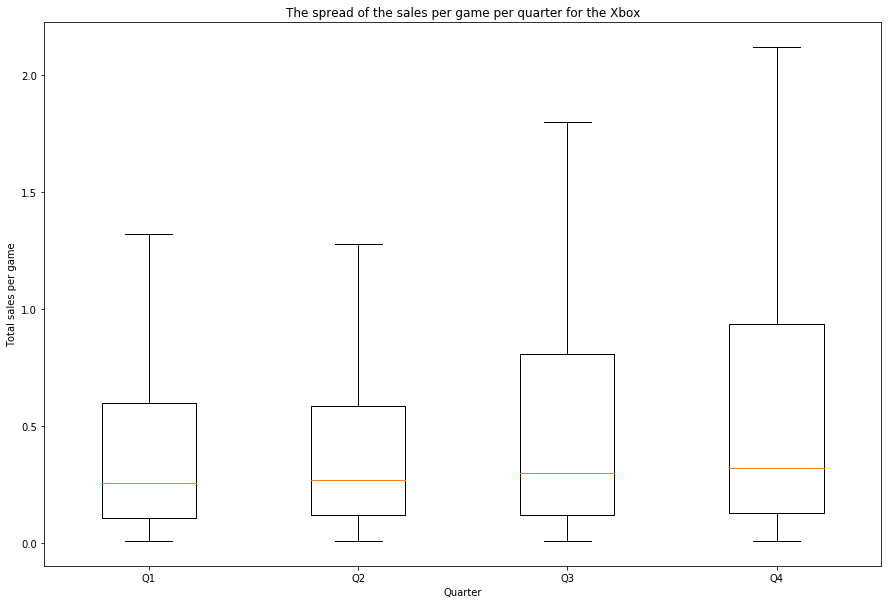

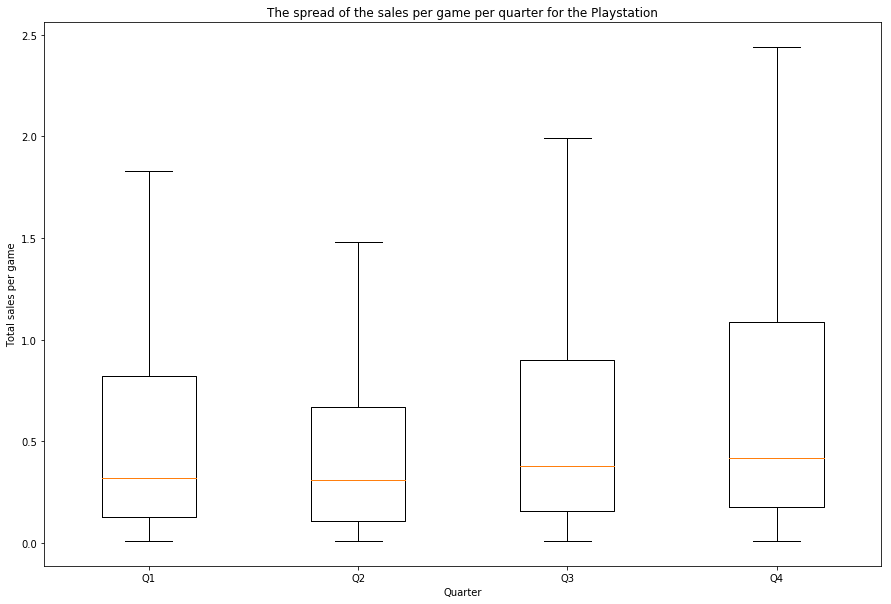

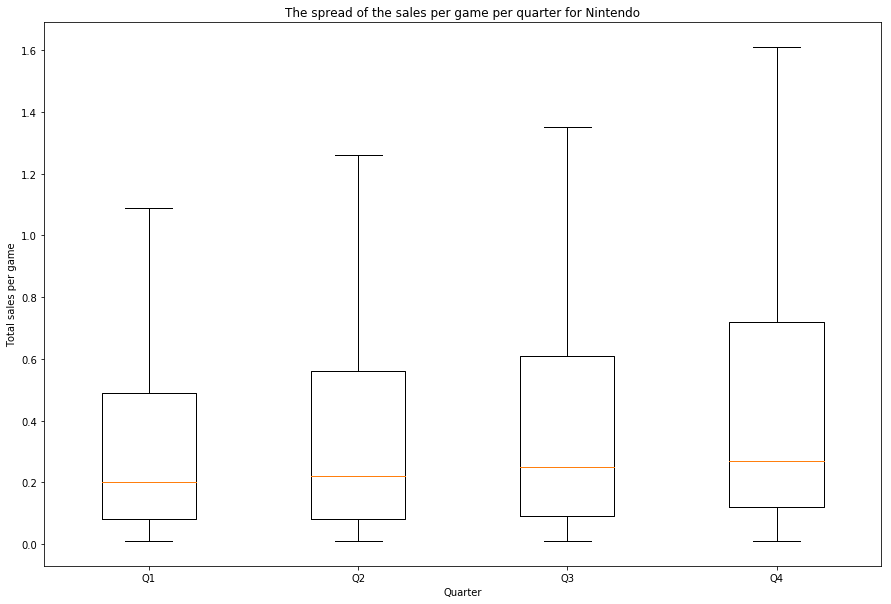

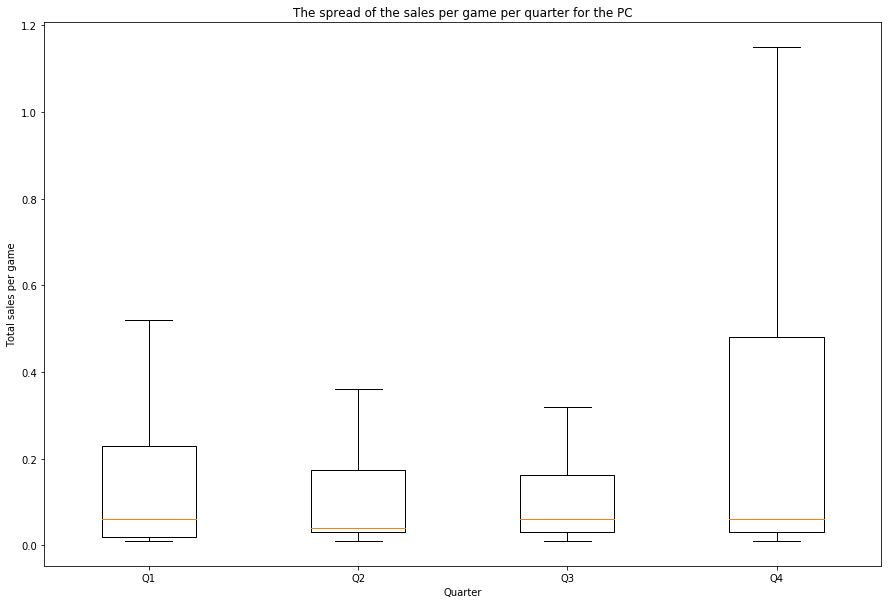

In [9]:
# Xbox
scores = get_all_from_data(key_score, data_xbox)
sales = get_all_from_data(key_global, data_xbox)
genres, genre_data = split_categorical_key(key_genre, data_xbox)
quarters, quarter_data = split_categorical_key(key_release_q, data_xbox)
genre_data = from_lod_to_dol(genre_data)
quarter_data= from_lod_to_dol(quarter_data)

plot_box_plot(quarter_data, ['Q1', 'Q2', 'Q3', 'Q4'], sales, 'Total sales per game', 'Quarter', 'The spread of the sales per game per quarter for the Xbox')


# PlayStation
scores = get_all_from_data(key_score, data_playstation)
sales = get_all_from_data(key_global, data_playstation)
genres, genre_data = split_categorical_key(key_genre, data_playstation)
quarters, quarter_data = split_categorical_key(key_release_q, data_playstation)
genre_data = from_lod_to_dol(genre_data)
quarter_data= from_lod_to_dol(quarter_data)

plot_box_plot(quarter_data, ['Q1', 'Q2', 'Q3', 'Q4'], sales, 'Total sales per game', 'Quarter', 'The spread of the sales per game per quarter for the Playstation')


# Ninendo
scores = get_all_from_data(key_score, data_nintendo)
sales = get_all_from_data(key_global, data_nintendo)
genres, genre_data = split_categorical_key(key_genre, data_nintendo)
quarters, quarter_data = split_categorical_key(key_release_q, data_nintendo)
genre_data = from_lod_to_dol(genre_data)
quarter_data= from_lod_to_dol(quarter_data)

plot_box_plot(quarter_data, ['Q1', 'Q2', 'Q3', 'Q4'], sales, 'Total sales per game', 'Quarter', 'The spread of the sales per game per quarter for Nintendo')


# PC
scores = get_all_from_data(key_score, data_pc)
sales = get_all_from_data(key_global, data_pc)
genres, genre_data = split_categorical_key(key_genre, data_pc)
quarters, quarter_data = split_categorical_key(key_release_q, data_pc)
genre_data = from_lod_to_dol(genre_data)
quarter_data= from_lod_to_dol(quarter_data)

plot_box_plot(quarter_data, ['Q1', 'Q2', 'Q3', 'Q4'], sales, 'Total sales per game', 'Quarter', 'The spread of the sales per game per quarter for the PC')

As can be seen in the previous plots there is mostlikely a correlation between how many sales there will be in which quarter relatively to the other quarters. According to these findings most of the sales happen in the fourth quarter, while the second quarter is most of the time at the bottom. So it would be promissing to expand the Lineair regression models to not only predict the big-hit genre of the next year, but do the same for approximating which big-hit genre will happen in each of the quarters.

### Different Lineair regression models
As of now we will mainly be testing with two different lineair regression models which will use ordinary least squares to fit the parameters. Finally we will also test a third model, but this one won't be tested in depth.

- The first model will use the score and genre to create the model: $$Sales = score*X_0 + genre*X_1$$
 
- The second model will then also use score and genre, but this time also use genre multiplied by score, which results in a situation where there will be a balance of where the score influences a specific genre:
$$Sales = score*X_0 + genre*X_1 + genre*score*X_2$$

- The last model will be a model that will only use the genre to try to predict the sales:
$$Sales = genre*X_0$$ 

### The three LRM models
In this section we will test the three different models ($Sales = score*X + genre*X$, $Sales = score*X + genre*X + genre*score*X$ and $Sales = genre*X$) to see what kind of accuracies these models will give for each year.

The accuracy of such a model is an indication of how accurate the model was in predicting the n big-hits. To further optimise these tests we will be checking two situations in which we will look at the nr 1 big hit genre and the top 5 big hit genres. In addition to this we will be testing the models using all the games from all the years before and only using the data of two years before. Finally we will test these two situations to predict a whole year and for each quarter of a specific year.

In [86]:
def calc_LinR_model_Cat(data, sort_reg): 
    # Put the target (Global Sales -- Global_Sales) in another DataFrame
    dfs = []
    for i, d in enumerate(data):
        dfs.append(pd.DataFrame(data[i], columns=keys))
        
#     If we want to do the model with score, or without score.
    fit = []
    if sort_reg == 1:
        for dfi in dfs:
            fit.append(smf.ols(formula=key_global + ' ~ ' + key_score + ' + ' + 'C(' + key_genre + ')', data=dfi).fit())
    elif sort_reg == 0:
        for dfi in dfs:
            fit.append(smf.ols(formula=key_global + ' ~ ' + 'C(' + key_genre + ')', data=dfi).fit())
    elif sort_reg == 2: 
        for i, dfi in enumerate(dfs):
            genres = get_unique_from_data(key_genre, data[i])
            formula = key_global + ' ~ ' + key_score + ' + ' + 'C(' + key_genre + ') + ' + 'C(' + key_genre + ') * ' + key_score
            fit.append(smf.ols(formula=formula, data=dfi).fit())
            
    return fit[0], fit[1], fit[2], fit[3]

def calc_LinR_model_Cat_in_years(data, sort_reg):  
    # Put the target (Global Sales -- Global_Sales) in another DataFrame
    df = pd.DataFrame(data, columns=keys)
    #     If we want to do the model with score, or without score or score * genre.
    if sort_reg == 1:
        fit = smf.ols(formula=key_global + ' ~ ' + key_score + ' + ' + 'C(' + key_genre + ')', data=df).fit()
    elif sort_reg == 0:
        fit = smf.ols(formula=key_global + ' ~ ' + 'C(' + key_genre + ')', data=df).fit()
    elif sort_reg == 2:  
        genres = get_unique_from_data(key_genre, data)
        formula = key_global + ' ~ ' + key_score + ' + ' + 'C(' + key_genre + ')' + ' + C(' + key_genre + ') * ' + key_score 
        fit = smf.ols(formula=formula, data=df).fit()
    return fit
    

years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016]

# Gets the games of all the data, splits it in quarters.
def get_games_of_year_in_quarters(begin_year, end_year, data):  
    quarter1 = []
    quarter2 = []
    quarter3 = []
    quarter4 = []
    for row in data:
        if int(row[key_release_y]) <= end_year and int(row[key_release_y]) >= begin_year:
            if row[key_release_q] == 'Q1':
                quarter1.append(row)
            elif row[key_release_q] == 'Q2':
                quarter2.append(row)
            elif row[key_release_q] == 'Q3':
                quarter3.append(row)
            elif row[key_release_q] == 'Q4':
                quarter4.append(row)
    return quarter1, quarter2, quarter3, quarter4, quarter1 + quarter2 + quarter3 + quarter4 

# Gets the hits for the actual data representing the big hits.
def get_hits_in_quarters(data):
    q = 1
    y = 0
    quarter1 = []
    quarter2 = []
    quarter3 = []
    quarter4 = []
    
    for item in data:
        if q == 1:
            quarter1.append(item)
            q += 1
        elif q == 2:
            quarter2.append(item)
            q += 1
        elif q == 3:
            quarter3.append(item)
            q += 1
        elif q == 4:
            quarter4.append(item)
            q = 1
        y += 1
        
    return quarter1, quarter2, quarter3, quarter4

def get_accuracy1_5(predicted_data, actual_data, sort_reg):
    if 'score' in predicted_data.params:
        params = predicted_data.params.drop(labels=['score'])
    else:
        params = predicted_data.params
    if sort_reg == 2:
        temp_params = params.to_dict()
        params = dict()
        for key in temp_params:
            if ':score' in key:
                params[key] = temp_params[key]
        params = pd.Series(params)

    number1 = params.nlargest(1).keys()[0]

    if number1 in 'Intercept':
        number1 = 'C(Genre)[T.Action]'
    if len(predicted_data.params) - 1 < 3:
        top5 = params.nlargest(len(params)).keys().tolist()
    else:
        top5 = params.nlargest(3).keys().tolist()

    returnable = [0,0]

    if actual_data in number1[11:-1]:
        returnable[0] = 1

    for i in range(len(top5)):
        if top5[i] in 'Intercept':
            top5[i] = 'C(Genre)[T.Action]'
        top5item = top5[i][11:-1]
        
        if actual_data in top5item:
            returnable[1] = (3 - i) / 3
            
    return returnable

In [87]:
def gen_y_error(data, big_hits, real_accuracy, year, model_version, year_version, top_version, key, sort_reg, noise=0.2, times=10):   
    worst_error = 0
    if sort_reg == 0:
        return worst_error
    
    for _ in range(times):
        temp_data = [dict(row) for row in data]
        
        for i in range(len(temp_data)):
            temp_data[i][key] += np.random.normal(0, noise)

        if year_version == True:
            q1, q2, q3, q4, y = get_games_of_year_in_quarters(2000, year - 1, temp_data)
        else:
            q1, q2, q3, q4, y = get_games_of_year_in_quarters(year - 5, year - 1, temp_data)

        # calc lin model
        if model_version == 1:
            model = calc_LinR_model_Cat([q1, q2, q3, q4], sort_reg)
        else:
            model = calc_LinR_model_Cat_in_years(y, sort_reg)
        
        # calc accuracy
        if model_version == 1:
            noisy_accuracy = (get_accuracy1_5(model[0], big_hits[0][year - 2000], sort_reg)[top_version] + \
                    get_accuracy1_5(model[1], big_hits[1][year - 2000], sort_reg)[top_version] + \
                    get_accuracy1_5(model[2], big_hits[2][year - 2000], sort_reg)[top_version] + \
                    get_accuracy1_5(model[3], big_hits[3][year - 2000], sort_reg)[top_version]) / 4
        else:
            noisy_accuracy = get_accuracy1_5(model, big_hits[year - 2000], sort_reg)[top_version]       
        
        if abs(real_accuracy - noisy_accuracy) > abs(worst_error):
            worst_error = real_accuracy - noisy_accuracy

    return worst_error

In [88]:
fin = open('data/big_hits_Xbox.csv', 'r')
big_hits_xbox = fin.read().split('\n')

fin = open('data/big_hits_PlayStation.csv', 'r')
big_hits_playstation = fin.read().split('\n')

fin = open('data/big_hits_Nintendo.csv', 'r')
big_hits_nintendo = fin.read().split('\n')

fin = open('data/big_hits_PC.csv', 'r')
big_hits_pc = fin.read().split('\n')

fin = open('data/big_hit_per_year_Xbox.csv', 'r')
big_hit_per_year_xbox = fin.read().split('\n')

fin = open('data/big_hit_per_year_PlayStation.csv', 'r')
big_hit_per_year_playstation = fin.read().split('\n')

fin = open('data/big_hit_per_year_Nintendo.csv', 'r')
big_hit_per_year_nintendo = fin.read().split('\n')

fin = open('data/big_hit_per_year_PC.csv', 'r')
big_hit_per_year_pc = fin.read().split('\n')

quarter_hits_xbox = get_hits_in_quarters(big_hits_xbox)
quarter_hits_playstation = get_hits_in_quarters(big_hits_playstation)
quarter_hits_nintendo = get_hits_in_quarters(big_hits_nintendo)
quarter_hits_pc = get_hits_in_quarters(big_hits_pc)

In [96]:
def do_accuracy_test_for_four_methods(based_on_all_years, sort_reg):
    method1all = []
    method2all = []
    method3all = []
    method4all = []

    method1xbox = []
    method2xbox = []
    method3xbox = []
    method4xbox = []

    method1play = []
    method2play = []
    method3play = []
    method4play = []

    method1nint = []
    method2nint = []
    method3nint = []
    method4nint = []

    method1pc = []
    method2pc = []
    method3pc = []
    method4pc = []
    
    begin_year_regex = 0
   
    for i in range(4, len(years) - 1):
        if based_on_all_years:
            begin_year_regex = 0
        else:
            begin_year_regex = i - 4
            
        quarter1, quarter2, quarter3, quarter4, allquarters = get_games_of_year_in_quarters(years[begin_year_regex], years[i], data_xbox)
        q1, q2, q3, q4 = calc_LinR_model_Cat([quarter1, quarter2, quarter3, quarter4], sort_reg)
        y = calc_LinR_model_Cat_in_years(allquarters, sort_reg)

        q1method1x, q1method2x = get_accuracy1_5(q1, quarter_hits_xbox[0][i + 1], sort_reg)
        q2method1x, q2method2x = get_accuracy1_5(q2, quarter_hits_xbox[1][i + 1], sort_reg)
        q3method1x, q3method2x = get_accuracy1_5(q3, quarter_hits_xbox[2][i + 1], sort_reg)
        q4method1x, q4method2x = get_accuracy1_5(q4, quarter_hits_xbox[3][i + 1], sort_reg)
        ymethod3x, ymethod4x = get_accuracy1_5(y, big_hit_per_year_xbox[i + 1], sort_reg)

        quarter1, quarter2, quarter3, quarter4, allquarters = get_games_of_year_in_quarters(years[begin_year_regex], years[i], data_playstation)
        q1, q2, q3, q4 = calc_LinR_model_Cat([quarter1, quarter2, quarter3, quarter4], sort_reg)
        y = calc_LinR_model_Cat_in_years(allquarters, sort_reg)

        q1method1ps, q1method2ps = get_accuracy1_5(q1, quarter_hits_playstation[0][i + 1], sort_reg)
        q2method1ps, q2method2ps = get_accuracy1_5(q2, quarter_hits_playstation[1][i + 1], sort_reg)
        q3method1ps, q3method2ps = get_accuracy1_5(q3, quarter_hits_playstation[2][i + 1], sort_reg)
        q4method1ps, q4method2ps = get_accuracy1_5(q4, quarter_hits_playstation[3][i + 1], sort_reg)
        ymethod3ps, ymethod4ps = get_accuracy1_5(y, big_hit_per_year_playstation[i + 1], sort_reg)


        quarter1, quarter2, quarter3, quarter4, allquarters = get_games_of_year_in_quarters(years[begin_year_regex], years[i], data_nintendo)
        q1, q2, q3, q4 = calc_LinR_model_Cat([quarter1, quarter2, quarter3, quarter4], sort_reg)
        y = calc_LinR_model_Cat_in_years(allquarters, sort_reg)

        q1method1n, q1method2n = get_accuracy1_5(q1, quarter_hits_nintendo[0][i + 1], sort_reg)
        q2method1n, q2method2n = get_accuracy1_5(q2, quarter_hits_nintendo[1][i + 1], sort_reg)
        q3method1n, q3method2n = get_accuracy1_5(q3, quarter_hits_nintendo[2][i + 1], sort_reg)
        q4method1n, q4method2n = get_accuracy1_5(q4, quarter_hits_nintendo[3][i + 1], sort_reg)
        ymethod3n, ymethod4n = get_accuracy1_5(y, big_hit_per_year_nintendo[i + 1], sort_reg)


        quarter1, quarter2, quarter3, quarter4, allquarters = get_games_of_year_in_quarters(years[begin_year_regex], years[i], data_pc)
        q1, q2, q3, q4 = calc_LinR_model_Cat([quarter1, quarter2, quarter3, quarter4], sort_reg)
        y = calc_LinR_model_Cat_in_years(allquarters, sort_reg)

        q1method1pc, q1method2pc = get_accuracy1_5(q1, quarter_hits_pc[0][i + 1], sort_reg)
        q2method1pc, q2method2pc = get_accuracy1_5(q2, quarter_hits_pc[1][i + 1], sort_reg)
        q3method1pc, q3method2pc = get_accuracy1_5(q3, quarter_hits_pc[2][i + 1], sort_reg)
        q4method1pc, q4method2pc = get_accuracy1_5(q4, quarter_hits_pc[3][i + 1], sort_reg)
        ymethod3pc, ymethod4pc = get_accuracy1_5(y, big_hit_per_year_pc[i + 1], sort_reg)


        method1all.append((q1method1x + q2method1x + q3method1x + q4method1x +
                       q1method1ps + q2method1ps + q3method1ps + q4method1ps +
                       q1method1n + q2method1n + q3method1n + q4method1n +
                       q1method1pc + q2method1pc + q3method1pc + q4method1pc) / 16)
        method2all.append((q1method2x + q2method2x + q3method2x + q4method2x +
                       q1method2ps + q2method2ps + q3method2ps + q4method2ps +
                       q1method2n + q2method2n + q3method2n + q4method2n +
                       q1method2pc + q2method2pc + q3method2pc + q4method2pc) / 16)
        method3all.append((ymethod3x + ymethod3ps + ymethod3n + ymethod3pc) / 4)
        method4all.append((ymethod4x + ymethod4ps + ymethod4n + ymethod4pc) / 4)

        method1xbox.append((q1method1x + q2method1x + q3method1x + q4method1x) / 4)
        method2xbox.append((q1method2x + q2method2x + q3method2x + q4method2x) / 4)   
        method3xbox.append(ymethod3x)
        method4xbox.append(ymethod4x)

        method1play.append((q1method1ps + q2method1ps + q3method1ps + q4method1ps) / 4)
        method2play.append((q1method2ps + q2method2ps + q3method2ps + q4method2ps) / 4)  
        method3play.append(ymethod3ps)
        method4play.append(ymethod4ps)

        method1nint.append((q1method1n + q2method1n + q3method1n + q4method1n) / 4)
        method2nint.append((q1method2n + q2method2n + q3method2n + q4method2n) / 4)
        method3nint.append(ymethod3n)
        method4nint.append(ymethod4n)

        method1pc.append((q1method1pc + q2method1pc + q3method1pc + q4method1pc) / 4)
        method2pc.append((q1method2pc + q2method2pc + q3method2pc + q4method2pc) / 4)
        method3pc.append(ymethod3pc)
        method4pc.append(ymethod4pc)
        
    start_y = 4


    plt.plot(years[start_y:-1], method1all, color='purple')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hits per quarter of the year we trying to predict for every console')
    plt.show()

    plt.plot(years[start_y:-1], method2all, color='purple')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hit per quarter for every console')
    plt.show()

    plt.plot(years[start_y:-1], method3all, color='purple')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hit of the year we trying to predict for every console')
    plt.show()

    plt.plot(years[start_y:-1], method4all, color='purple')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hits of the year for every console')
    plt.show()


    
#   Xbox

    e_years = years[start_y:-1]
    y_errors = [gen_y_error(data_xbox, quarter_hits_xbox, method1xbox[i], e_years[i] + 1, 1, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method1xbox, yerr=y_errors, color="green", alpha=0.5)
    plt.plot(years[start_y:-1], method1xbox, color="green")
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hits per quarter of the year we trying to predict on xbox')
    plt.show()
    
    y_errors = [gen_y_error(data_xbox, quarter_hits_xbox, method2xbox[i], e_years[i] + 1, 1, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method2xbox, yerr=y_errors, color="green", alpha=0.5)
    plt.plot(years[start_y:-1], method2xbox, color="green")
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hit per quarter on xbox')
    plt.show()

    y_errors = [gen_y_error(data_xbox, big_hit_per_year_xbox, method3xbox[i], e_years[i] + 1, 0, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method3xbox, yerr=y_errors, color="green", alpha=0.5)
    plt.plot(years[start_y:-1], method3xbox, color='green')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hit of the year we trying to predict on Xbox')
    plt.show()

    y_errors = [gen_y_error(data_xbox, big_hit_per_year_xbox, method4xbox[i], e_years[i] + 1, 0, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method4xbox, yerr=y_errors, color="green", alpha=0.5)
    plt.plot(years[start_y:-1], method4xbox, color='green')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hits of the year on Xbox')
    plt.show()

#     Playstation
    
    y_errors = [gen_y_error(data_playstation, quarter_hits_playstation, method1play[i], e_years[i] + 1, 1, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method1play, yerr=y_errors, color="blue", alpha=0.5)
    plt.plot(years[start_y:-1], method1play, color='blue')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hits per quarter of the year we trying to predict on playstation')
    plt.show()

    y_errors = [gen_y_error(data_playstation, quarter_hits_playstation, method2play[i], e_years[i] + 1, 1, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method2play, yerr=y_errors, color="blue", alpha=0.5)
    plt.plot(years[start_y:-1], method2play, color='blue')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hit per quarter on playstation')
    plt.show()

    y_errors = [gen_y_error(data_playstation, big_hit_per_year_playstation, method3play[i], e_years[i] + 1, 0, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method3play, yerr=y_errors, color="blue", alpha=0.5)
    plt.plot(years[start_y:-1], method3play, color='blue')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hit of the year we trying to predict on PlayStation')
    plt.show()

    y_errors = [gen_y_error(data_playstation, big_hit_per_year_playstation, method4play[i], e_years[i] + 1, 0, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method4play, yerr=y_errors, color="blue", alpha=0.5)
    plt.plot(years[start_y:-1], method4play, color='blue')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hits of the year on PlayStation')
    plt.show()

# Nintendo
    y_errors = [gen_y_error(data_nintendo, quarter_hits_nintendo, method1nint[i], e_years[i] + 1, 1, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method1nint, yerr=y_errors, color="red", alpha=0.5)
    plt.plot(years[start_y:-1], method1nint, color='red')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hits per quarter of the year we trying to predict on nintendo')
    plt.show()

    y_errors = [gen_y_error(data_nintendo, quarter_hits_nintendo, method2nint[i], e_years[i] + 1, 1, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method2nint, yerr=y_errors, color="red", alpha=0.5)
    plt.plot(years[start_y:-1], method2nint, color='red')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hit per quarter on nintendo')
    plt.show()

    y_errors = [gen_y_error(data_nintendo, big_hit_per_year_nintendo, method3nint[i], e_years[i] + 1, 0, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method3nint, yerr=y_errors, color="red", alpha=0.5)
    plt.plot(years[start_y:-1], method3nint, color='red')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hit of the year we trying to predict on Nintendo')
    plt.show()

    y_errors = [gen_y_error(data_nintendo, big_hit_per_year_nintendo, method4nint[i], e_years[i] + 1, 0, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method4nint, yerr=y_errors, color="red", alpha=0.5)
    plt.plot(years[start_y:-1], method4nint, color='red')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hits of the year on Nintendo')
    plt.show()

# PC
    y_errors = [gen_y_error(data_pc, quarter_hits_pc, method1pc[i], e_years[i] + 1, 1, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method1pc, yerr=y_errors, color="orange", alpha=0.5)
    plt.plot(years[start_y:-1], method1pc, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hits per quarter of the year we trying to predict on pc')
    plt.show()

    y_errors = [gen_y_error(data_pc, quarter_hits_pc, method2pc[i], e_years[i] + 1, 1, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method2pc, yerr=y_errors, color="orange", alpha=0.5)
    plt.plot(years[start_y:-1], method2pc, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hit per quarter on pc')
    plt.show()

    y_errors = [gen_y_error(data_pc, big_hit_per_year_pc, method3pc[i], e_years[i] + 1, 0, based_on_all_years, 0, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method3pc, yerr=y_errors, color="orange", alpha=0.5)
    plt.plot(years[start_y:-1], method3pc, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the big hit of the year we trying to predict on pc')
    plt.show()

    y_errors = [gen_y_error(data_pc, big_hit_per_year_pc, method4pc[i], e_years[i] + 1, 0, based_on_all_years, 1, key_score, sort_reg) for i in range(len(e_years))]
    plt.errorbar(e_years, method4pc, yerr=y_errors, color="orange", alpha=0.5)
    plt.plot(years[start_y:-1], method4pc, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with comparing to the top 3 big hits of the year on pc')
    plt.show()


#### Error bars
Since giving a score always contains a bayes factor and therefore is impossible to give the exact perfect score we incorporated an error bar in the upcomming plots. This error bar indicates what the largest difference of accuracy could be if we would put a noise on each score. This noise will be uniformly picked from a range of 0 up to 0.2.

#### Accuracies for LRM model whith $Sales = score*X_0 + genre*X_1$  using data of the 4 previous years

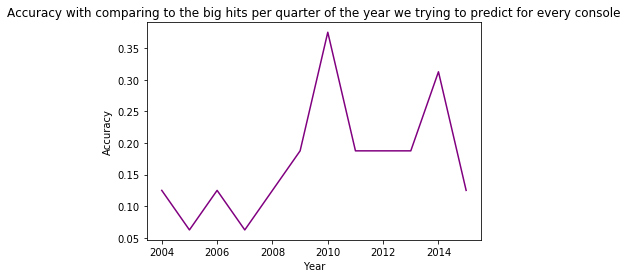

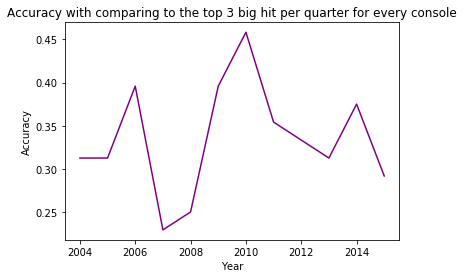

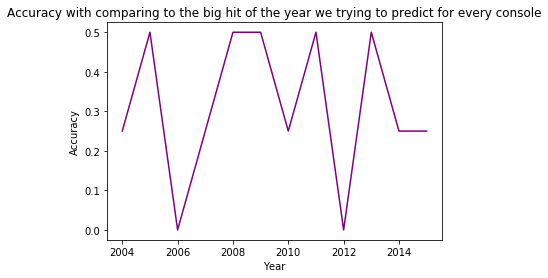

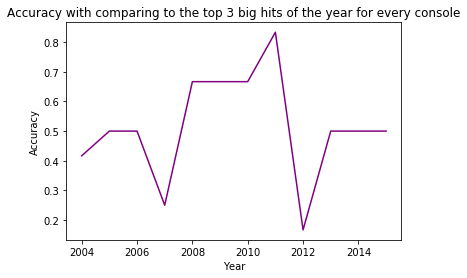

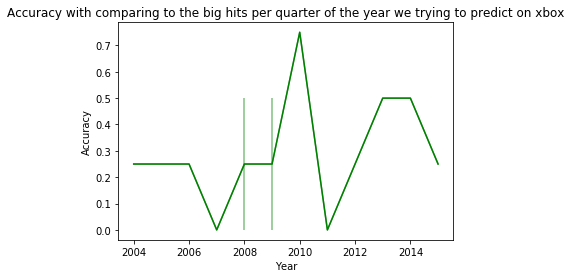

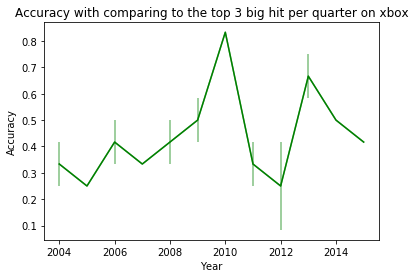

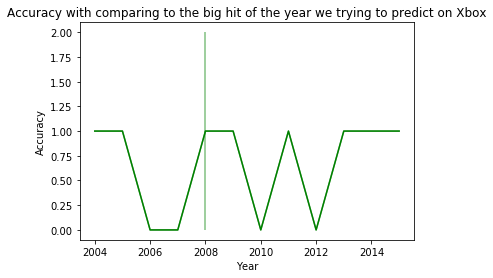

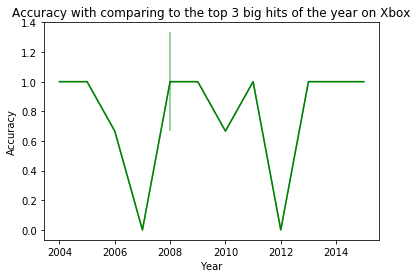

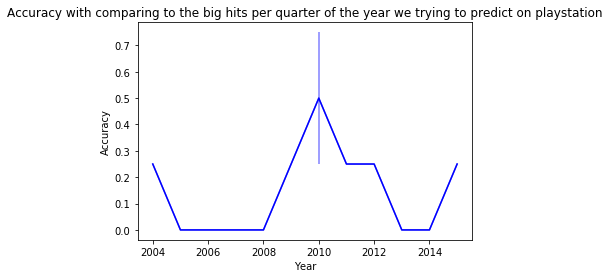

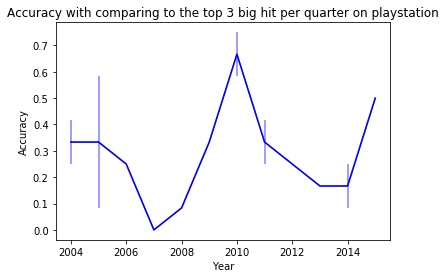

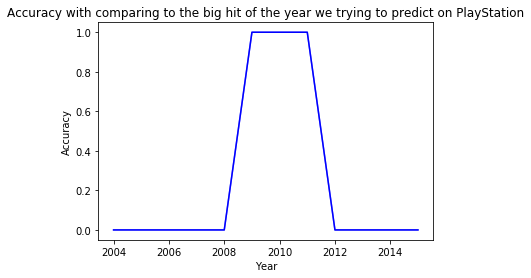

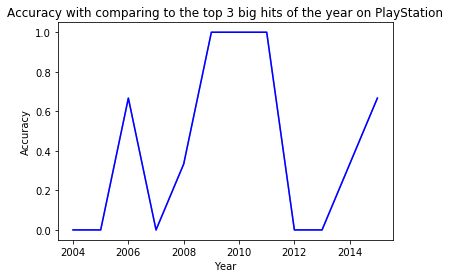

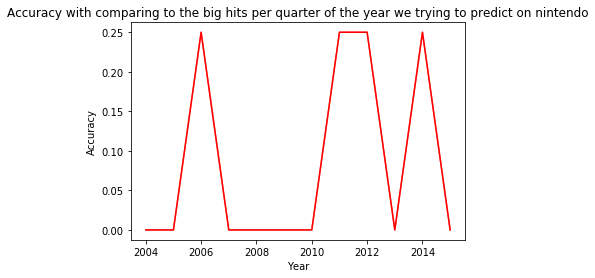

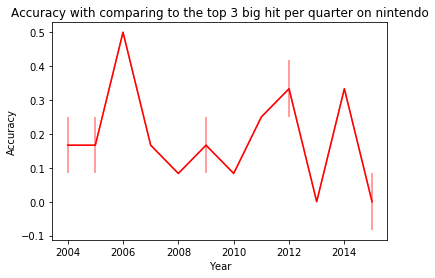

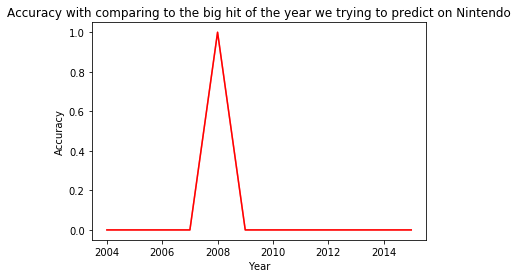

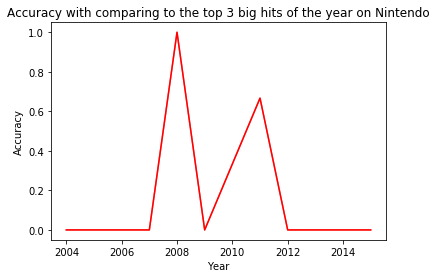

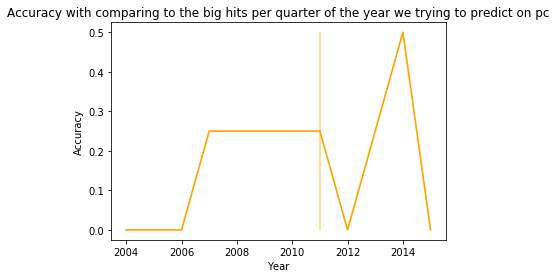

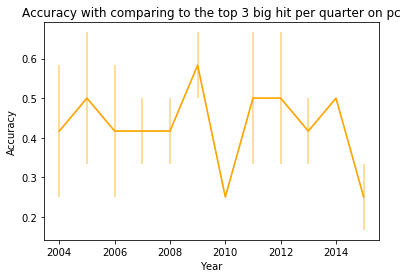

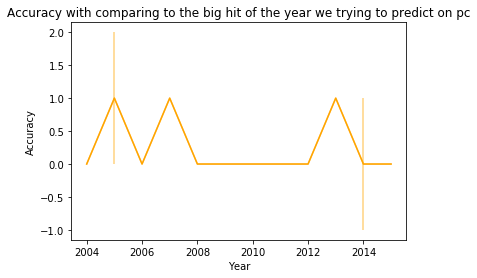

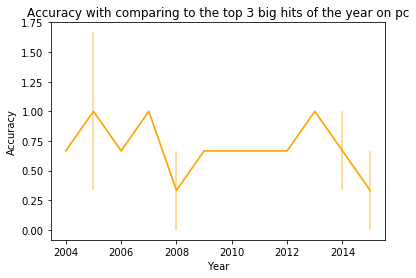

In [97]:
do_accuracy_test_for_four_methods(False, 1)

#### Accuracies for LRM model whith $Sales = score*X_0 + genre*X_1$  using data of all the previous years

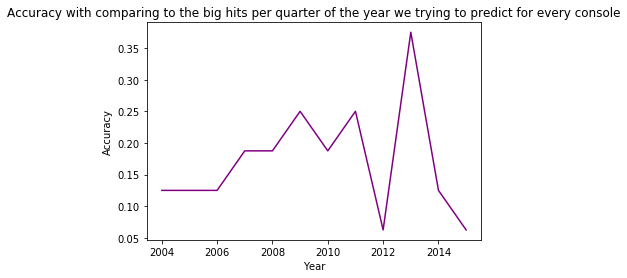

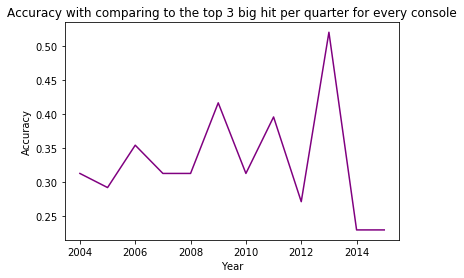

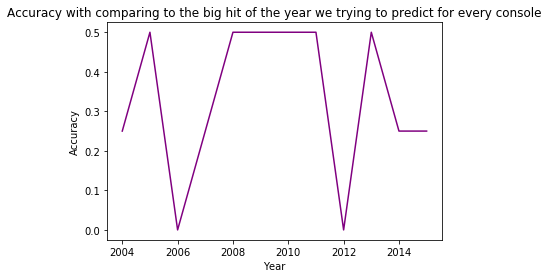

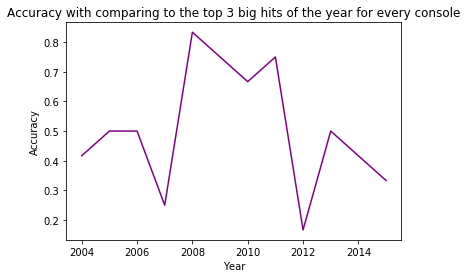

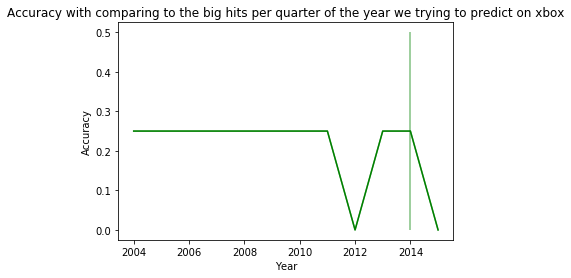

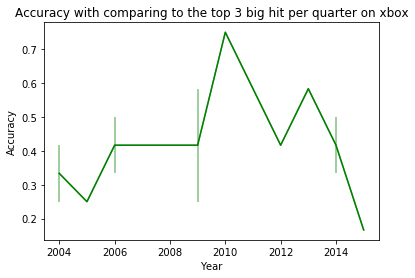

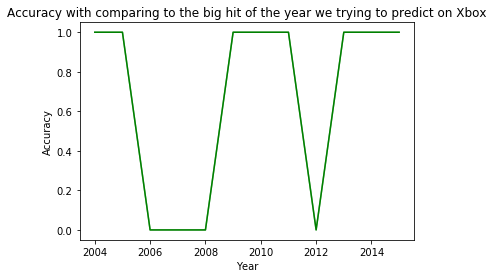

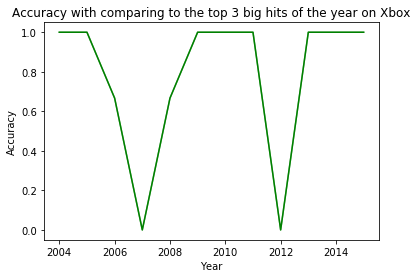

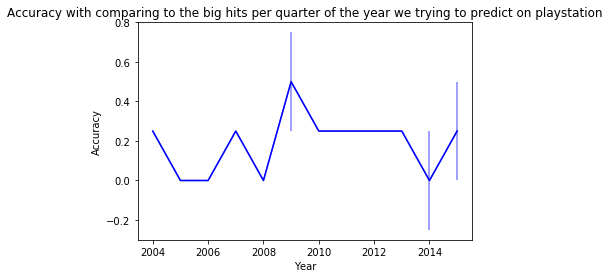

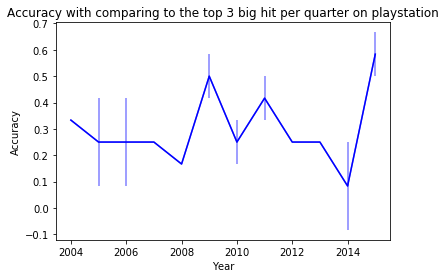

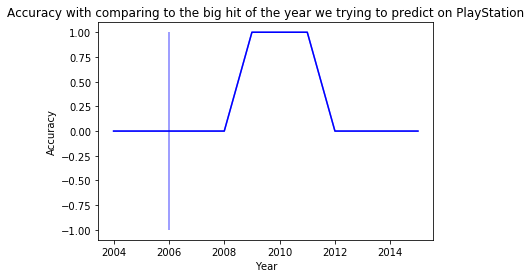

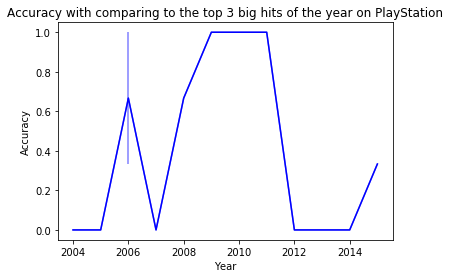

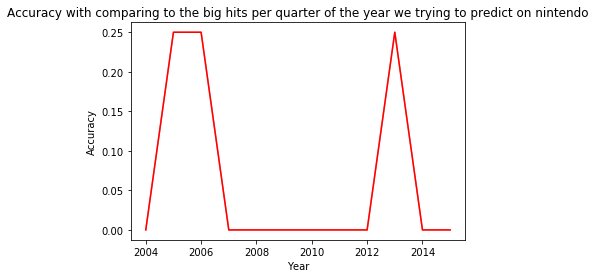

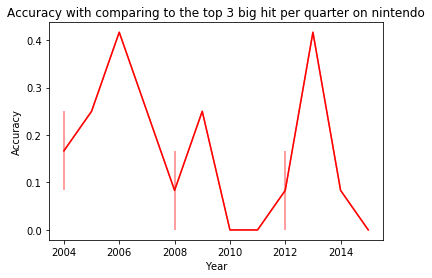

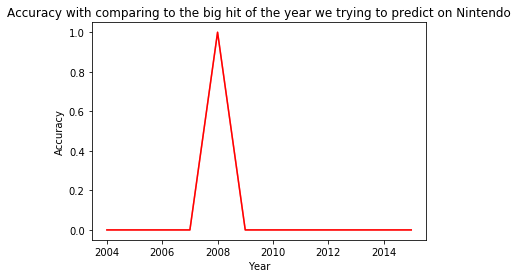

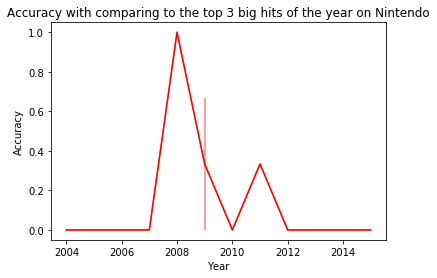

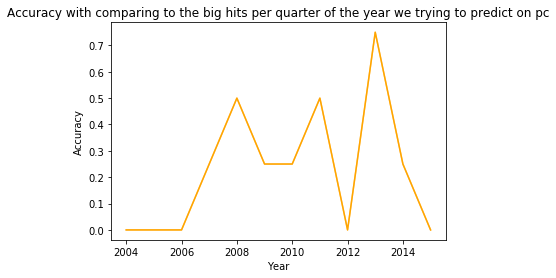

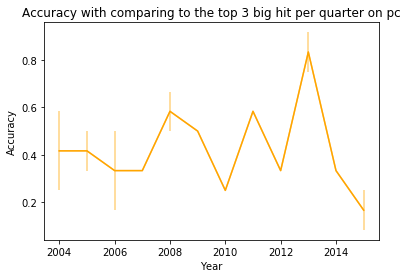

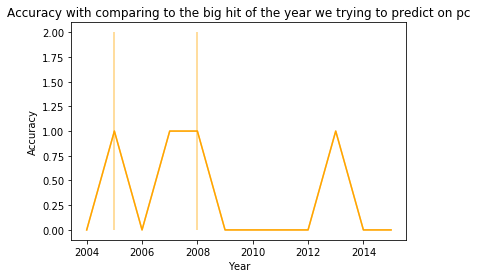

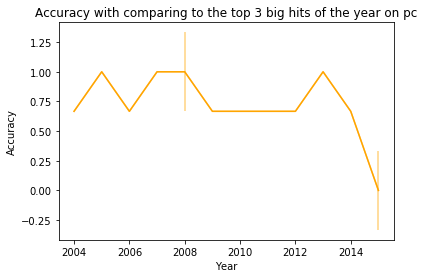

In [98]:
do_accuracy_test_for_four_methods(True, 1)

#### Accuracies for LRM model whith $Sales = score*X_0 + genre*X_1 + genre*score*X_2$ using data of the 4 previous years

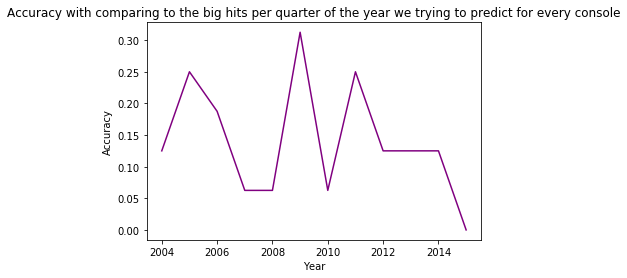

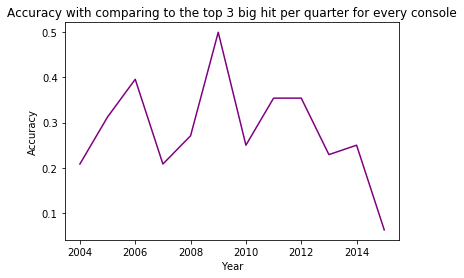

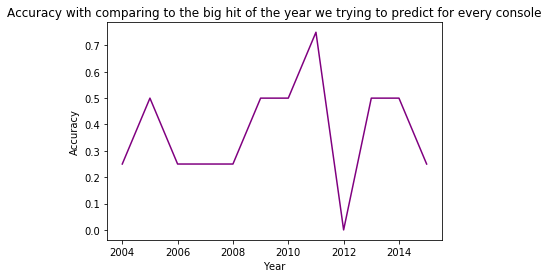

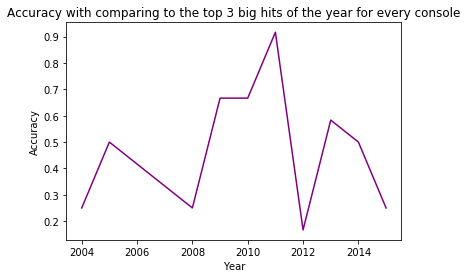

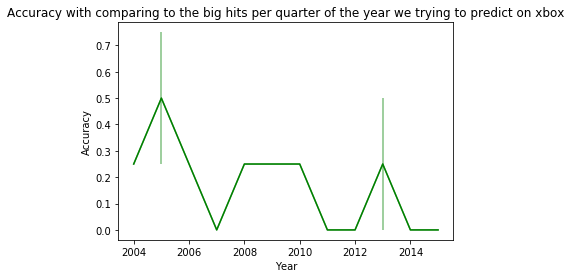

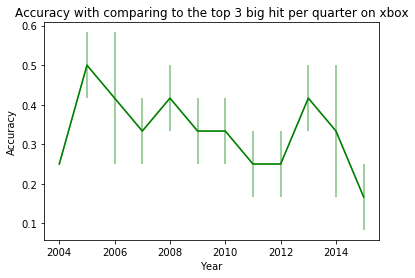

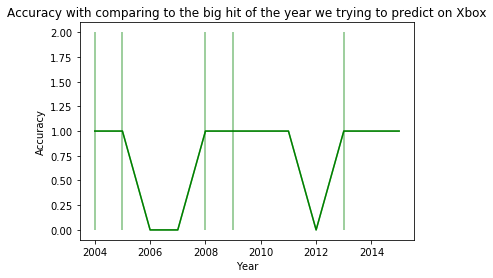

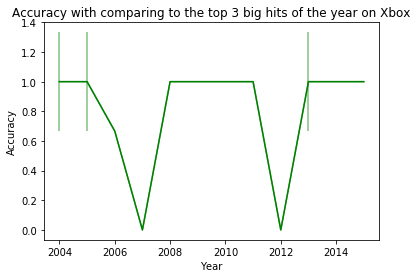

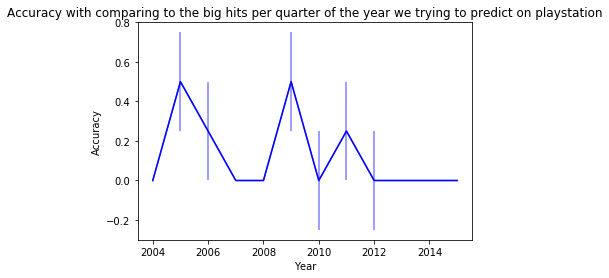

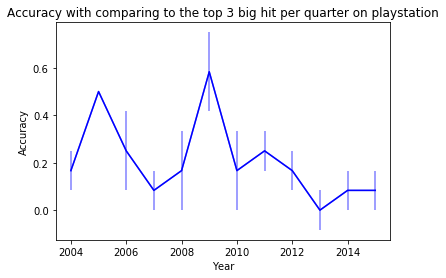

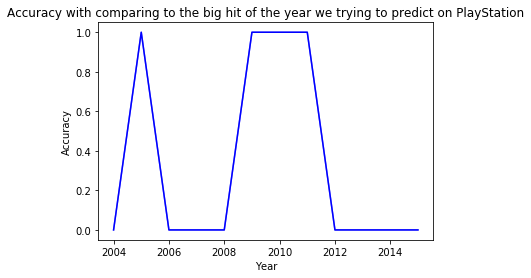

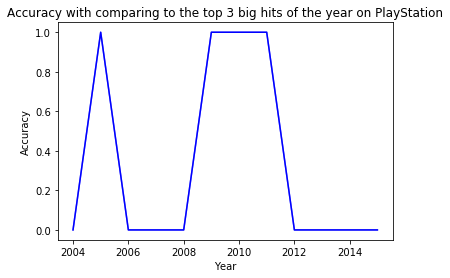

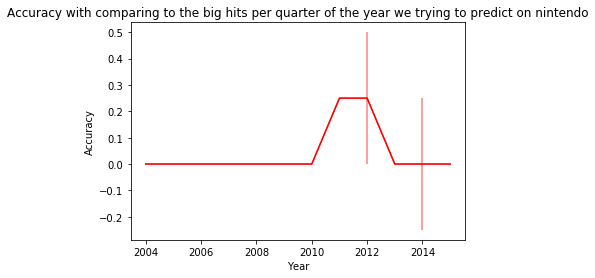

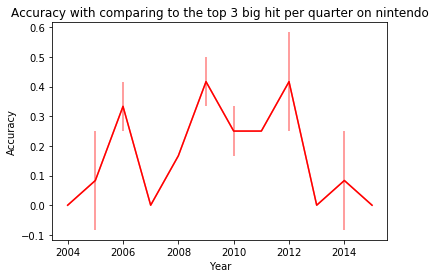

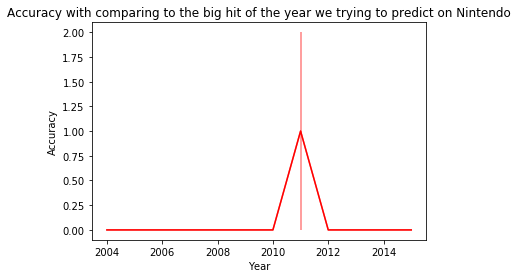

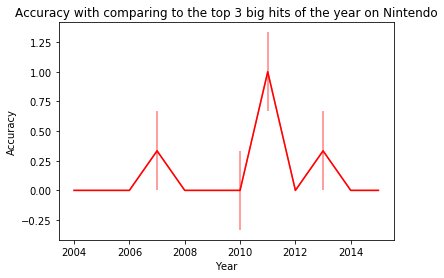

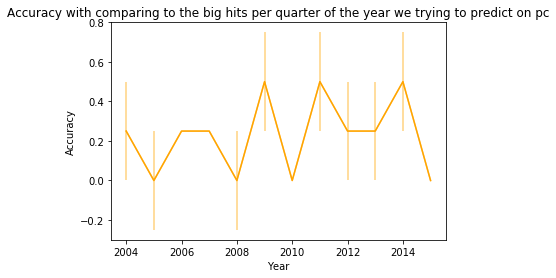

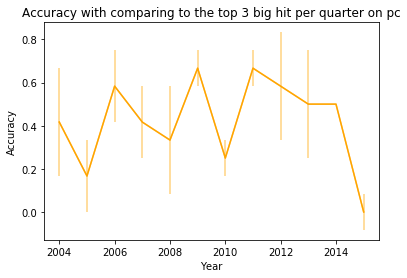

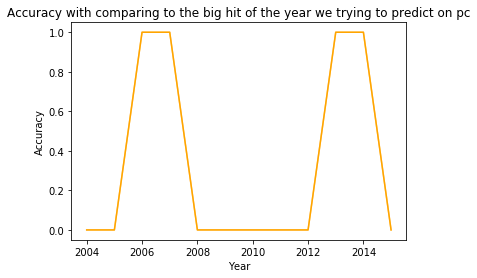

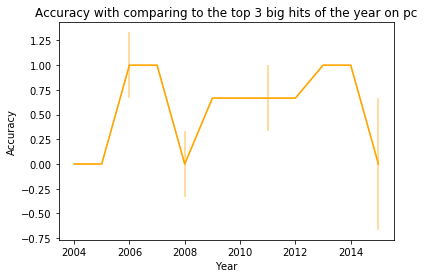

In [99]:
do_accuracy_test_for_four_methods(False, 2)

#### Accuracies for LRM model whith $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of all the previous years

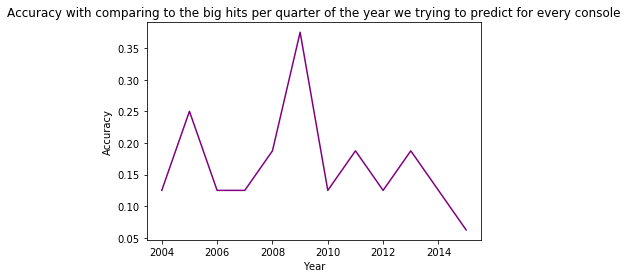

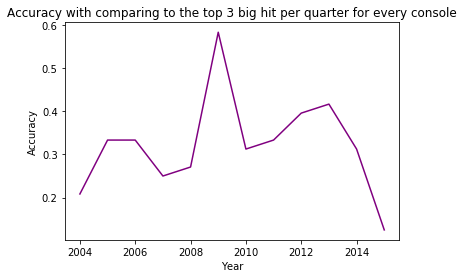

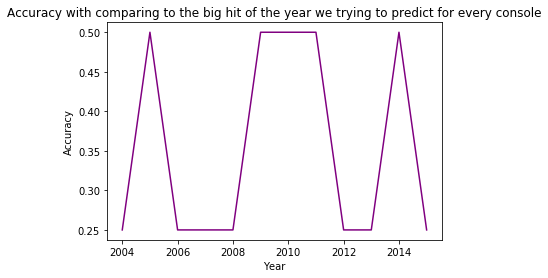

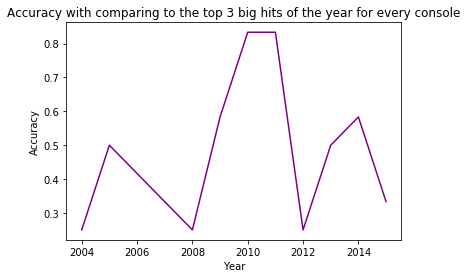

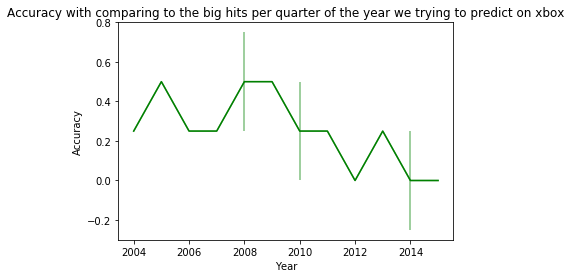

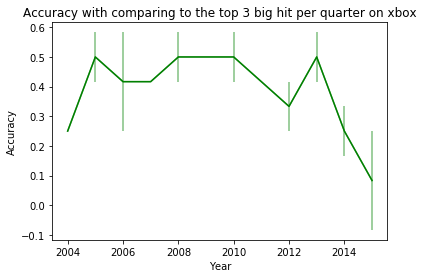

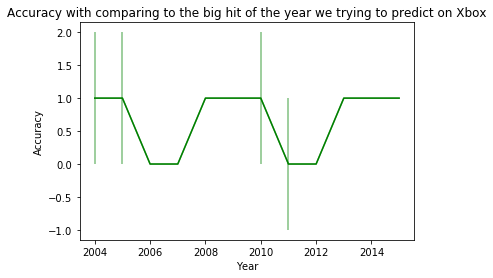

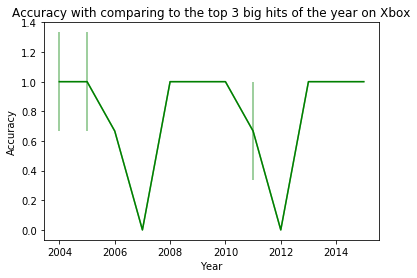

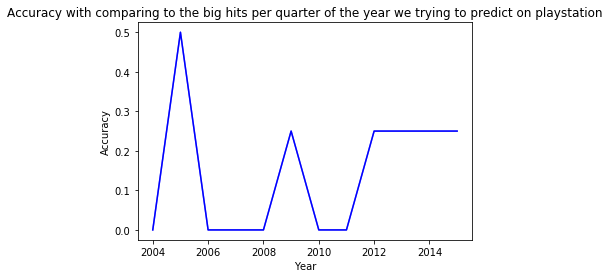

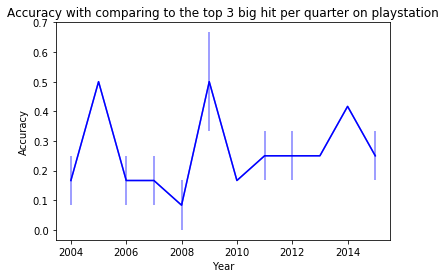

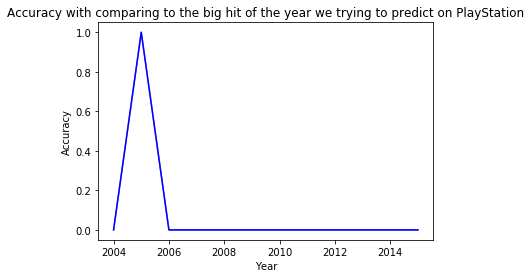

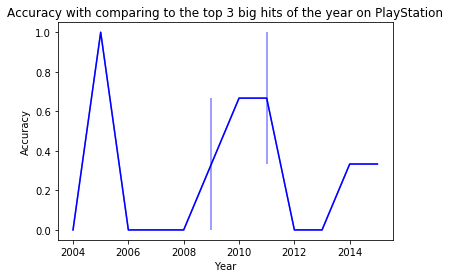

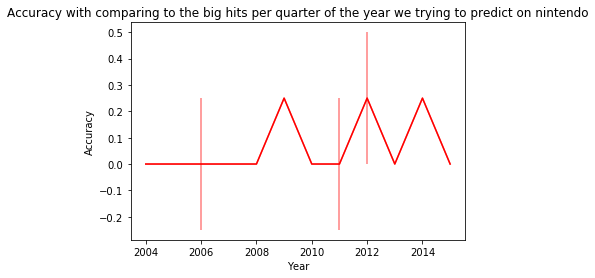

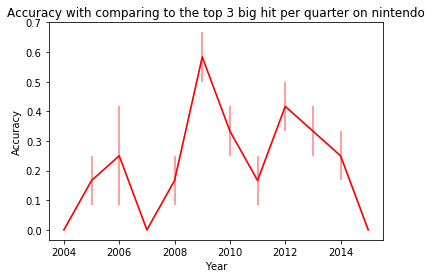

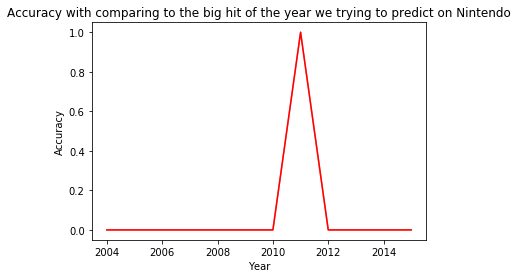

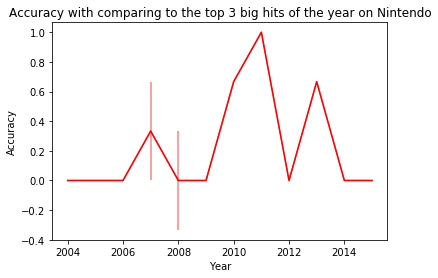

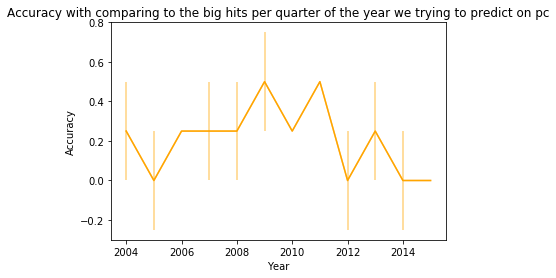

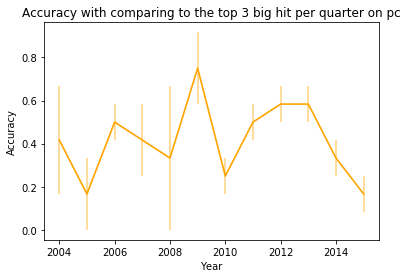

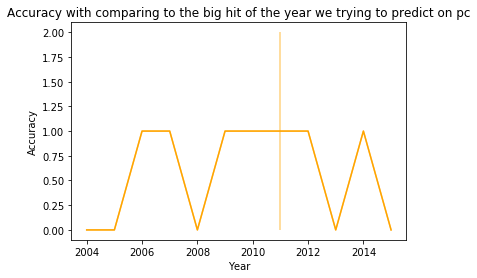

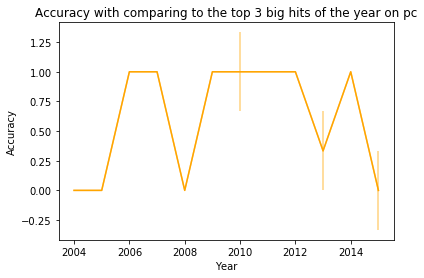

In [100]:
do_accuracy_test_for_four_methods(True, 2)

#### Accuracies for LRM model whith $Sales = genre*X_0$ using data of the 4 previous years

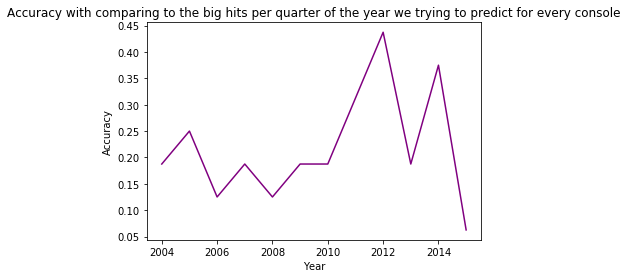

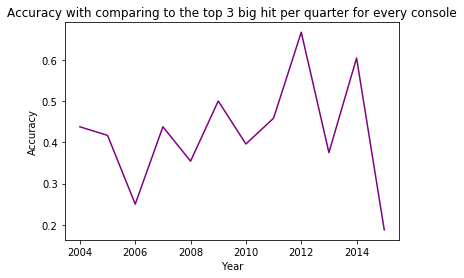

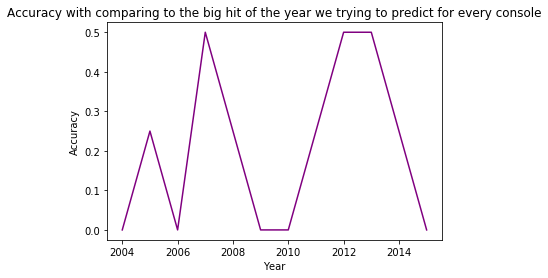

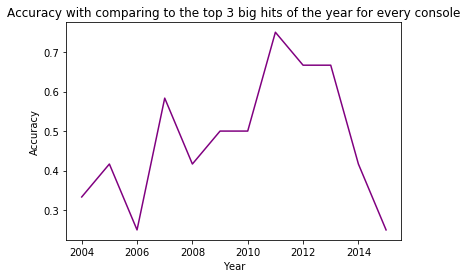

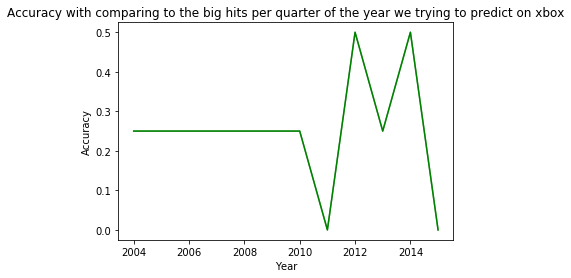

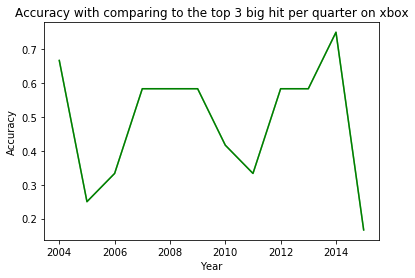

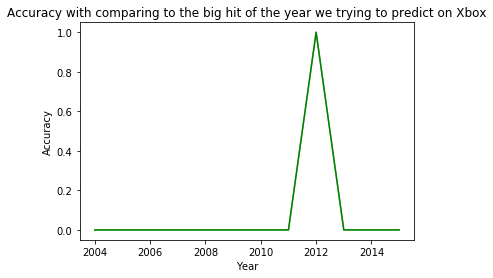

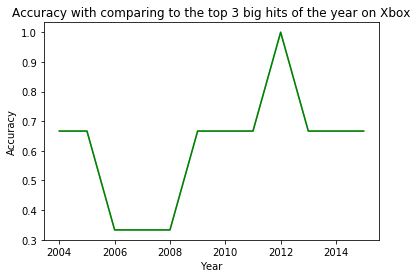

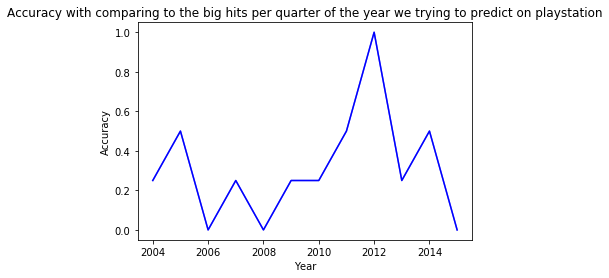

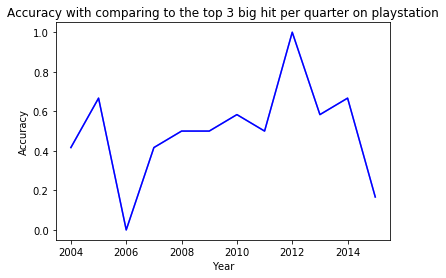

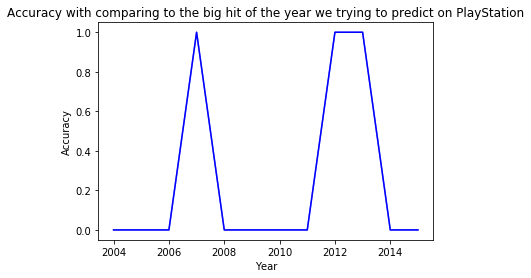

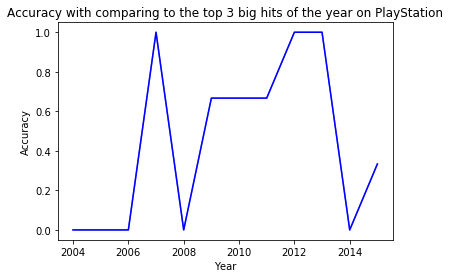

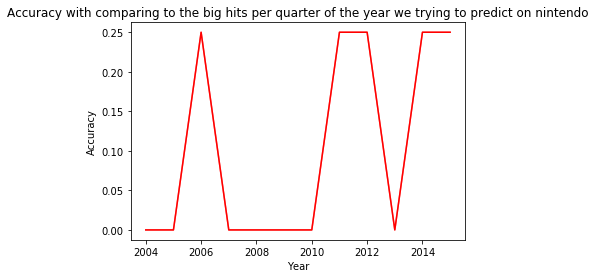

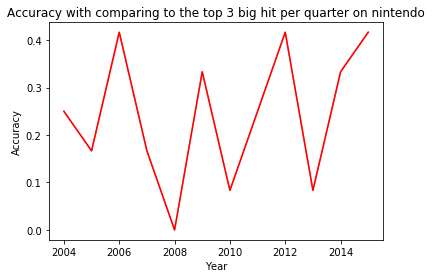

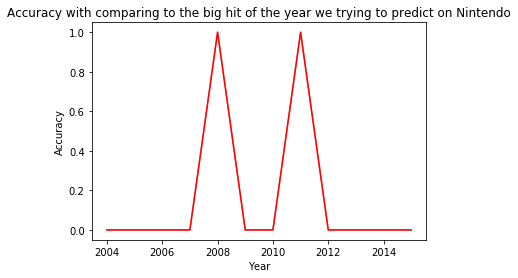

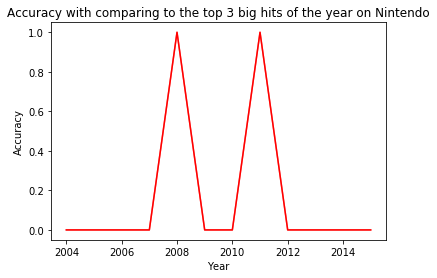

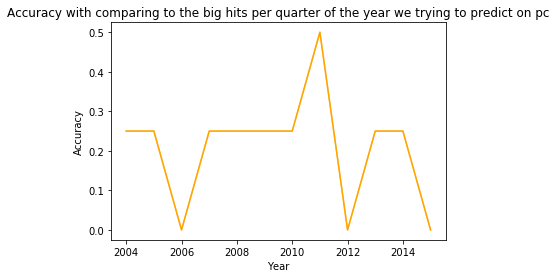

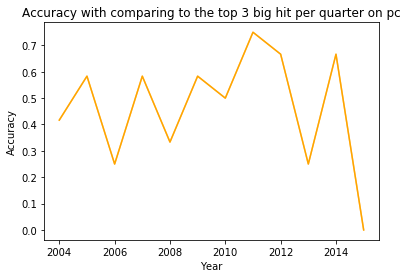

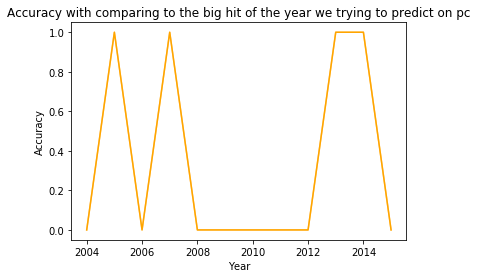

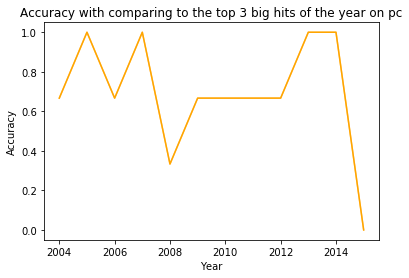

In [101]:
do_accuracy_test_for_four_methods(False, 0)

#### Accuracies for LRM model whith $Sales = genre*X_0$  using data of all the previous years

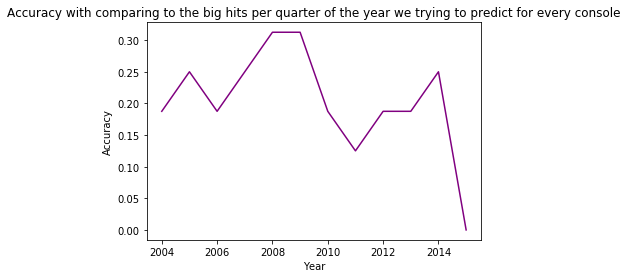

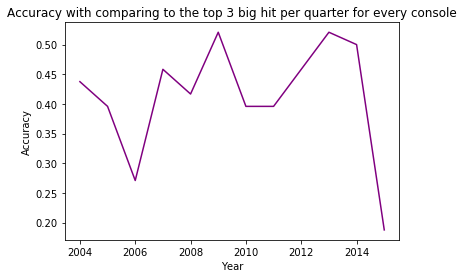

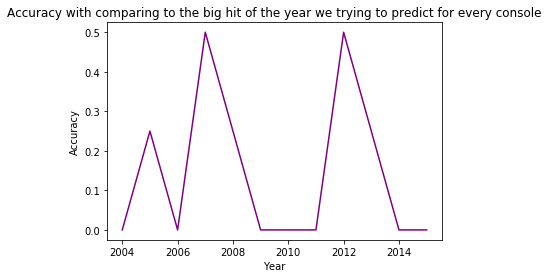

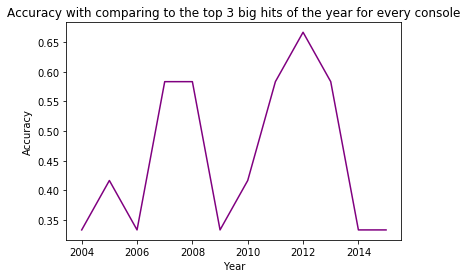

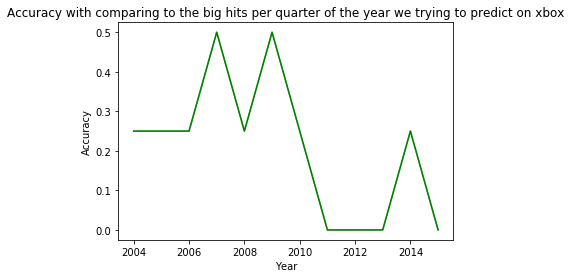

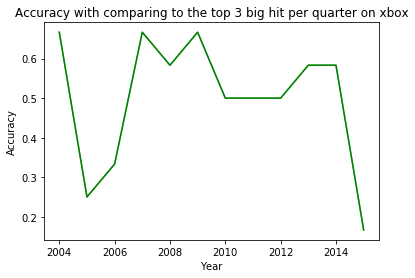

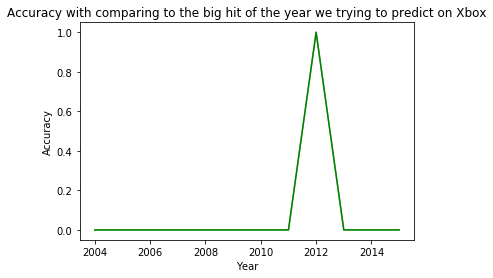

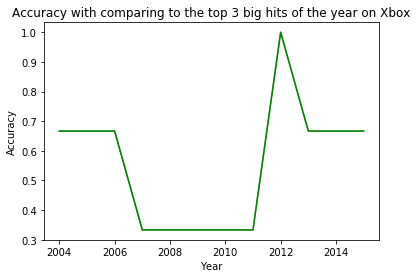

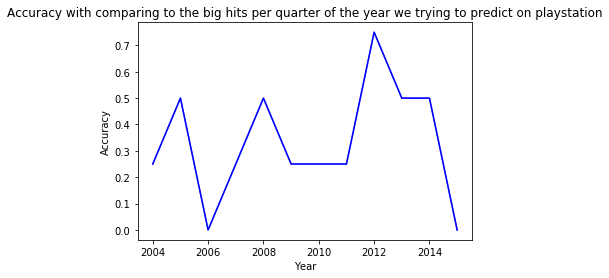

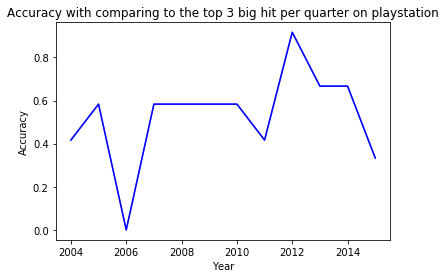

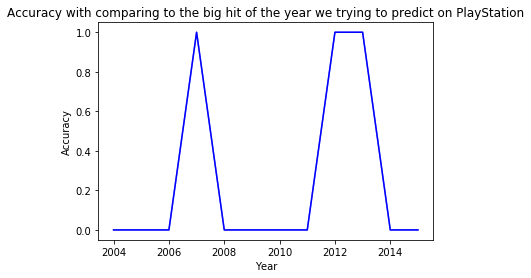

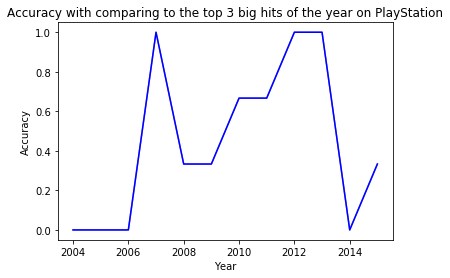

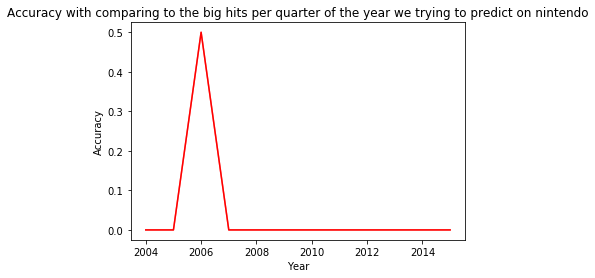

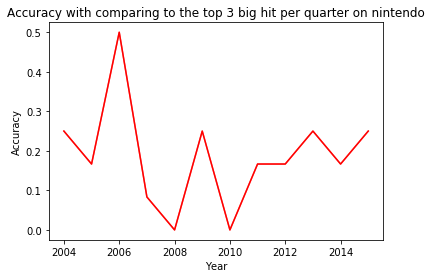

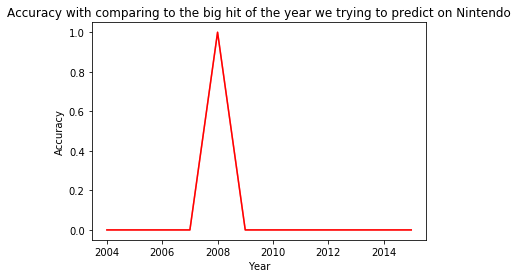

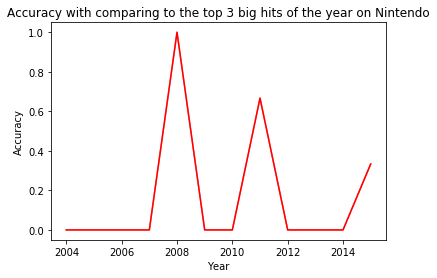

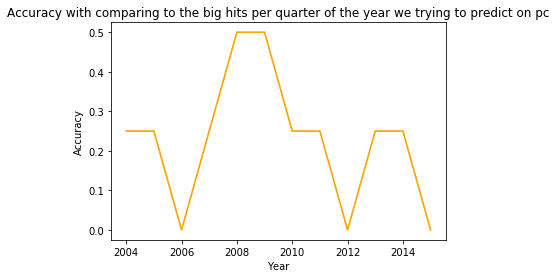

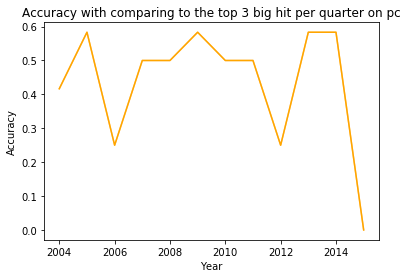

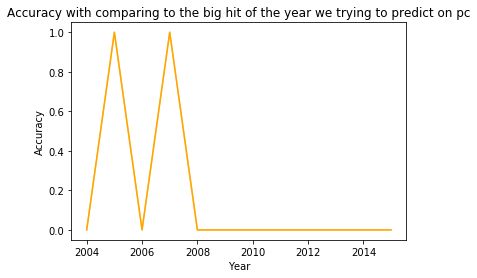

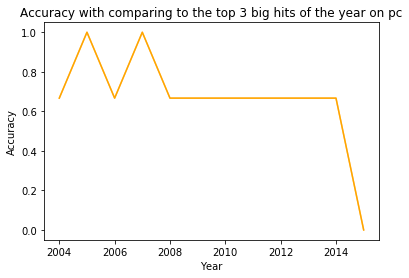

In [102]:
do_accuracy_test_for_four_methods(True, 0)

#### Results of the LRM
After testing the several lineir regression models we are able to see that in most of the situations the accuracy drops in the last couple years. When looking at a plot  shown earlier from the global analysis of the data we can also see that the number of games released in each year also drops in the last couple of years. This could be an explanation, of why our accuracy would drop in the last few years, since our model has less points to determine an exact model. 

### Average accuracy and stability of the LRM models using $Sales = score*X + genre*X$ and $Sales = score*X + genre*X + genre*score*X$

Now we know how our different models function over the years it would be a good next step to take a look at the average of all accuracies depending on how much noise we put on the scores. This could give an indication if our models would be better of, result with a better average accuracy, when using noisy score or not using scores at all.

For each of the two models we will show a plot of the accuracy (average correctness) of this LRM for a few years with difference levels of noise applied to the score. Noise is the $\sigma$ of the normally distributed random value added to the score.

Finally we will also show how stable these models are. The stability will indicate how much of the resulting predicted bighits stayed the same when aplying more noise on the model. These plots will give an indication of how much a person could be bayes when giving scores so that our model will give the same prediction.

In [77]:
def find_max_saled_game_in_dict_with_key(dictio, key):
    max_val = 0.0
    max_row = None
    for row in dictio:
        if float(row[key]) > max_val:
            max_val = float(row[key])
            max_row = row
    if max_row == None:
        max_row = {key_title: '---------', key_genre: '--', key_global: 0}
    return max_row

def get_big_hits_for_year(year, data, key):
    quarter1 = []
    quarter2 = []
    quarter3 = []
    quarter4 = []
    the_hit = []
    for row in data:
        if row[key_release_y] == year:
            if row[key_release_q] is 'Q1':
                quarter1.append(row)
            elif row[key_release_q] is 'Q2':
                quarter2.append(row)
            elif row[key_release_q] is 'Q3':
                quarter3.append(row)
            elif row[key_release_q] is 'Q4':
                quarter4.append(row)

    max1 = find_max_saled_game_in_dict_with_key(quarter1, key)
    max2 = find_max_saled_game_in_dict_with_key(quarter2, key)
    max3 = find_max_saled_game_in_dict_with_key(quarter3, key)
    max4 = find_max_saled_game_in_dict_with_key(quarter4, key)
    hit = find_max_saled_game_in_dict_with_key([max1, max2, max3, max4], key)
    
    return max1, max2, max3, max4, hit

def calc_LinR_model_Cat(data, sort_req = 2): 
    df1 = pd.DataFrame(data[0], columns=keys)
    df2 = pd.DataFrame(data[1], columns=keys)
    df3 = pd.DataFrame(data[2], columns=keys)
    df4 = pd.DataFrame(data[3], columns=keys)
    # Put the target (Global Sales -- Global_Sales) in another DataFrame
    
    if sort_reg == 2:
        f = key_global + ' ~ ' + key_const + ' + ' + key_score + ' + C(' + key_genre + ')' + ' + ' + key_score + ' * C(' + key_genre + ')'
    elif sort_reg == 1:
        f = key_global + ' ~ ' + key_const + ' + ' + key_score + ' + C(' + key_genre + ')'
    else:
        f = key_global + ' ~ ' + key_const + ' + C(' + key_genre + ')'

    fit1 = smf.ols(formula=f, data=df1).fit()
    fit2 = smf.ols(formula=f, data=df2).fit()
    fit3 = smf.ols(formula=f, data=df3).fit()
    fit4 = smf.ols(formula=f, data=df4).fit()    
    
    return fit1, fit2, fit3, fit4

def calc_LinR_model_Cat_in_years(data, sort_reg = 2):    
    df = pd.DataFrame(data, columns=keys)
    # Put the target (Global Sales -- Global_Sales) in another DataFrame
    
    if sort_reg == 2:
        f = key_global + ' ~ ' + ' + ' + key_score + ' + C(' + key_genre + ')' + ' + C(' + key_genre + ') * ' + key_score
    elif sort_reg == 1:
        f = key_global + ' ~ ' + ' + ' + key_score + ' + C(' + key_genre + ')'
    else:
        f = key_global + ' ~ ' + ' + C(' + key_genre + ')'
  
    return smf.ols(formula=f, data=df).fit()

# Gets the games of all the data, splits it in quarters.
def get_games_of_year_in_quarters(begin_year, end_year, data):  
    quarter1 = []
    quarter2 = []
    quarter3 = []
    quarter4 = []
    for row in data:
        if int(row[key_release_y]) <= end_year and int(row[key_release_y]) >= begin_year:
            if row[key_release_q] == 'Q1':
                quarter1.append(row)
            elif row[key_release_q] == 'Q2':
                quarter2.append(row)
            elif row[key_release_q] == 'Q3':
                quarter3.append(row)
            elif row[key_release_q] == 'Q4':
                quarter4.append(row)
    return quarter1, quarter2, quarter3, quarter4, quarter1 + quarter2 + quarter3 + quarter4 

# Gets the hits for the actual data representing the big hits.
def get_hits_in_quarters(data):
    quarter1 = [data[i] for i in range(0, len(data), 4)]
    quarter2 = [data[i] for i in range(1, len(data), 4)]
    quarter3 = [data[i] for i in range(2, len(data), 4)]
    quarter4 = [data[i] for i in range(3, len(data), 4)]
    
    return quarter1, quarter2, quarter3, quarter4

def get_accuracy(model_params, big_hit, top_size, sort_reg):
    if 'score' in model_params.params:
        params = model_params.params.drop(labels=['score'])
    else:
        params = model_params.params
        
    if sort_reg == 2:
        temp_params = params.to_dict()
        params = dict()
        for key in temp_params:
            if ':score' in key:
                params[key] = temp_params[key]
        params = pd.Series(params)
        
    if len(params) < top_size:
        top = params.nlargest(len(params)).keys().tolist()
    else:
        top = params.nlargest(top_size).keys().tolist()
    
    res = 0
    
    for i, item in enumerate(top):
        
        if item in 'Intercept':
            item = 'C(Genre)[T.Action]'
            
        item = top[i][11:-1]
        if big_hit in item:
            res = (len(top)-i) / len(top)
            return res
    return res

def get_stability(real_model, noisy_model, top_size, sort_reg):
    stability = 0
    
    if 'score' in real_model.params:
        r_params = real_model.params.drop(labels=['score'])
    else:
        r_params = real_model.params
        
    if 'score' in noisy_model.params:
        n_params = noisy_model.params.drop(labels=['score'])
    else:
        n_params = noisy_model.params
        
    if sort_reg == 2:
        temp_params = r_params.to_dict()
        r_params = dict()
        for key in temp_params:
            if ':score' in key:
                r_params[key] = temp_params[key]
        r_params = pd.Series(r_params)
        
        temp_params = n_params.to_dict()
        n_params = dict()
        for key in temp_params:
            if ':score' in key:
                n_params[key] = temp_params[key]
        n_params = pd.Series(n_params)
    
    if len(r_params) < top_size:
        r_top = r_params.nlargest(len(r_params)).keys().tolist()
    else:
        r_top = r_params.nlargest(top_size).keys().tolist()
    
    if len(n_params) < top_size:
        n_top = n_params.nlargest(len(n_params)).keys().tolist()
    else:
        n_top = n_params.nlargest(top_size).keys().tolist()
    
    for i in range(len(r_top)):
        if r_top[i] == n_top[i]:
            stability += 1 / top_size
    
    return stability

def lerp(a, b, v):
    #return (b - a) * v + a #this is faster but not numerically stable with a large difference between a and b
    return a * (1 - v) + b * v

def percentile(values, alpha):
    if len(values) == 0:
        return 0
    if len(values) == 1:
        return values[0]
    
    s = sorted(values)
    l = len(values) - 1
    
    idx_start = int(l * alpha)
    idx_end = idx_start + 1
    
    a = s[idx_start]
    b = s[idx_end]
    
    # linearly interpolate between the two values
    p_start = idx_start / l
    p_end = idx_end / l
    return lerp(a, b, (alpha - p_start) / (p_end - p_start))

def plot_accuracy_per_noise(data, big_hits, top_size, key, year_min, year_max, noise_min, noise_max, noise_steps=10, times=10, sort_reg = 2):   
    
    noise_range = np.linspace(noise_min, noise_max, noise_steps)
    accuracies = [[0.0 for _ in range(times)] for noise in noise_range]
    
    for y in range(year_min, year_max):
        q1, q2, q3, q4, year_games = get_games_of_year_in_quarters(y - 4, y - 1, data)
        if len(year_games) > 0:
            for i, noise in enumerate(noise_range):
                for j in range(times):
                    cur_games = [dict(game) for game in year_games]
                    for k in range(len(cur_games)):
                        cur_games[k][key] += np.random.normal(0, noise)
#                         cur_games[k][key] = np.clip(cur_games[k][key] + np.random.normal(0, noise), 0, 10)

                    model = calc_LinR_model_Cat_in_years(cur_games, sort_reg)
                    accuracies[i][j] += get_accuracy(model, big_hits[y - year_min], top_size, sort_reg) / (year_max - year_min)

    avgs = [percentile(acc, 0.5) for acc in accuracies]
    low = [percentile(acc, 0.025) for acc in accuracies]
    high = [percentile(acc, 0.975) for acc in accuracies]
    
    plt.plot(noise_range, low, label="Lower bound accuracy", alpha=0.5)
    plt.plot(noise_range, high, label="Higher bound accuracy", alpha=0.5)
    plt.plot(noise_range, avgs, label="Average accuracy")
    plt.legend()
    plt.xlabel("Noise")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per noise level with 95% confidence interval")

def plot_stability_per_noise(data, top_size, key, year_min, year_max, noise_min, noise_max, noise_steps=10, times=10, sort_reg = 2):   
    noise_range = np.linspace(noise_min, noise_max, noise_steps)
    stabilities = [[0.0 for _ in range(times)] for noise in noise_range]
    
    for y in range(year_min, year_max + 1):
        q1, q2, q3, q4, year_games = get_games_of_year_in_quarters(y - 4, y - 1, data)

        if len(year_games) > 0:
            real_model = calc_LinR_model_Cat_in_years(year_games)
            
            for i, noise in enumerate(noise_range):
                for j in range(times):
                    cur_games = [dict(game) for game in year_games]            
                    
                    for k in range(len(cur_games)):
                        cur_games[k][key] += np.random.normal(0, noise)
#                         cur_games[k][key] = np.clip(cur_games[k][key] + np.random.normal(0, noise), 0, 10)

                    
                    n_model = calc_LinR_model_Cat_in_years(cur_games)
                    stabilities[i][j] += get_stability(real_model, n_model, top_size, sort_reg) / (year_max - year_min + 1)

    avgs = [percentile(s, 0.5) for s in stabilities]
    low = [percentile(s, 0.025) for s in stabilities]
    high = [percentile(s, 0.975) for s in stabilities]
    
    plt.plot(noise_range, avgs, label="Average stability")
    plt.plot(noise_range, low, label="Lower bound stability", alpha=0.5)
    plt.plot(noise_range, high, label="Higher bound stability", alpha=0.5)
    plt.legend()
    plt.xlabel("Noise")
    plt.ylabel("Stability")
    plt.title("Stability over all years per noise level with 95% confidence interval")
    
top_size = 3
top_size1 = 2
top_size2 = 1

noise_min = 0.0001
noise_max = 5.0
noise_max1 = 1.0
noise_steps = 50
times = 25
year_min = 2004
year_max = 2015

def get_value_of_big_hits(data, key, year_min, year_max):
    
    big_hits = []
    big_hit_per_year = []
    for year in range(year_min, year_max):
        q1, q2, q3, q4, y = get_big_hits_for_year(year, data, key_global)
        big_hit_per_year.append(y[key])
        big_hits.append(q1[key])
        big_hits.append(q2[key])
        big_hits.append(q3[key])
        big_hits.append(q4[key])
        
    return big_hits, big_hit_per_year

big_hits, big_hit_per_year = get_value_of_big_hits(data, key_genre, year_min, year_max)
big_hits_xbox, big_hit_per_year_xbox = get_value_of_big_hits(data_xbox, key_genre, year_min, year_max)
big_hits_playstation, big_hit_per_year_playstation = get_value_of_big_hits(data_playstation, key_genre, year_min, year_max)
big_hits_nintendo, big_hit_per_year_nintendo = get_value_of_big_hits(data_nintendo, key_genre, year_min, year_max)
big_hits_pc, big_hit_per_year_pc = get_value_of_big_hits(data_pc, key_genre, year_min, year_max)

quarter_hits_xbox = get_hits_in_quarters(big_hits_xbox)
quarter_hits_playstation = get_hits_in_quarters(big_hits_playstation)
quarter_hits_nintendo = get_hits_in_quarters(big_hits_nintendo)
quarter_hits_pc = get_hits_in_quarters(big_hits_pc)


#### Top 3 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

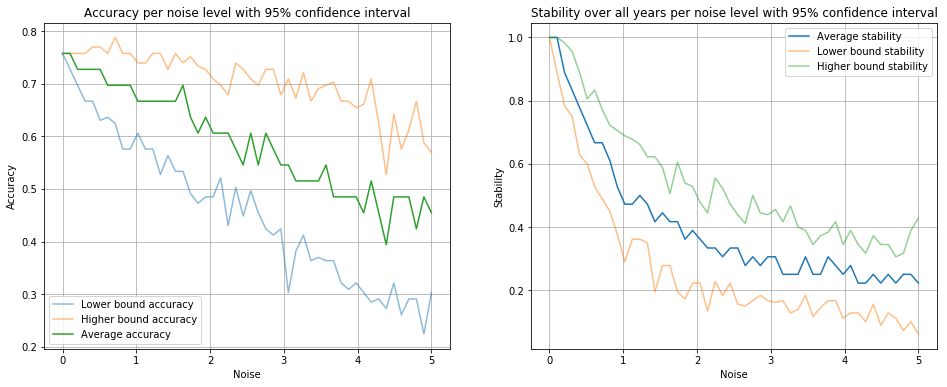

In [29]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 2 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

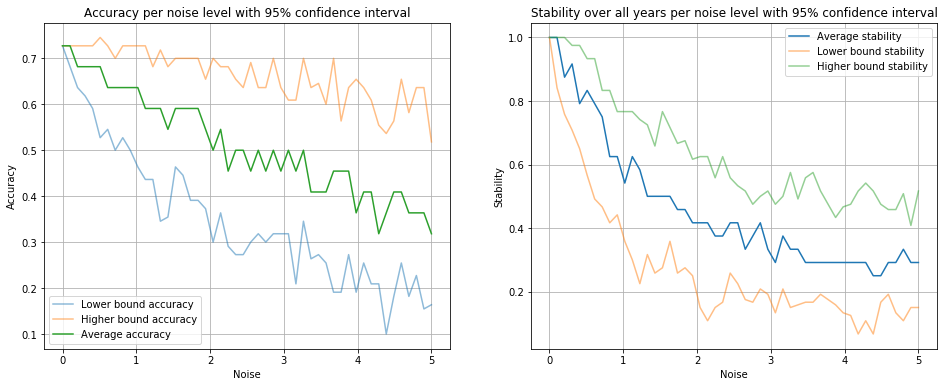

In [78]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 1 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

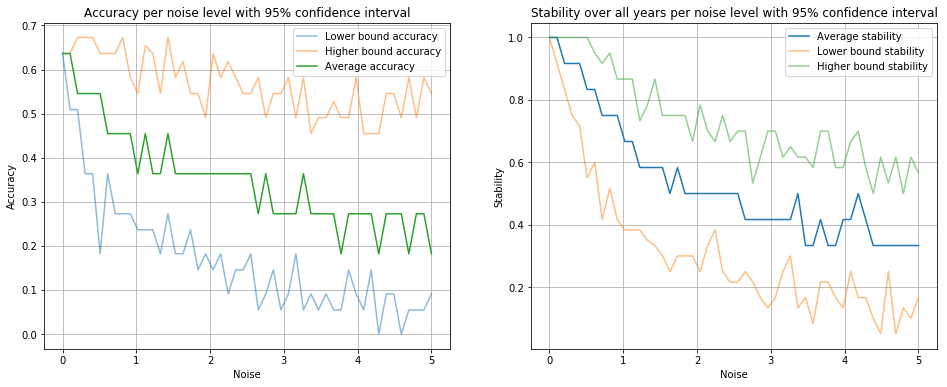

In [47]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 3 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

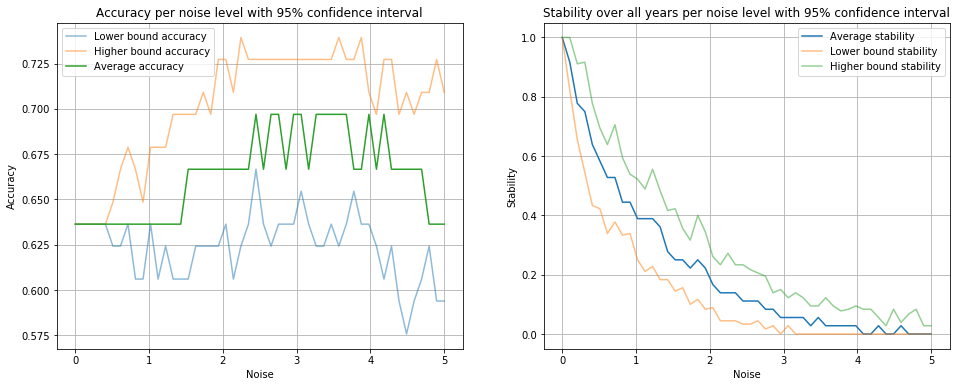

In [85]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 2 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of tthe previous 4 years

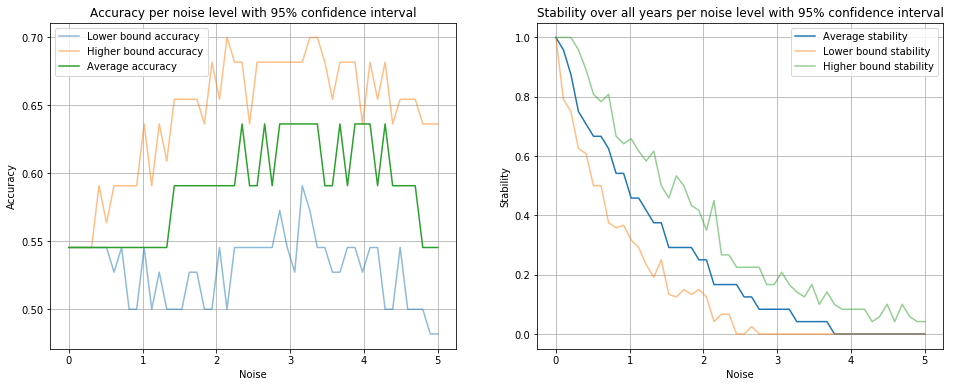

In [50]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 1 Xbox Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of tthe previous 4 years

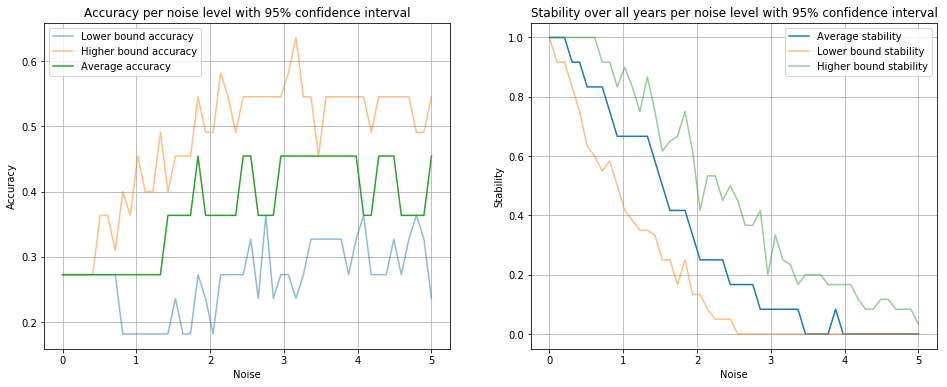

In [51]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_xbox, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### top 3 Xbox correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

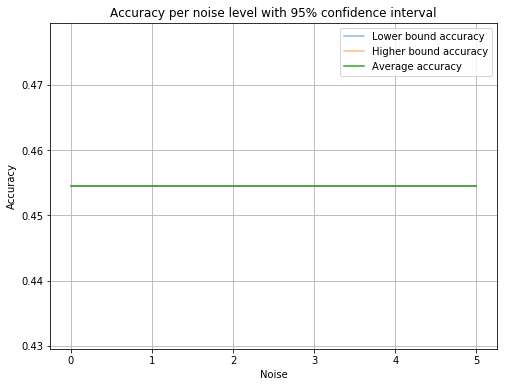

In [31]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### top 2 Xbox correctness accuracy for $Sales = genre * X_0$   using data up to 4 years back for each year

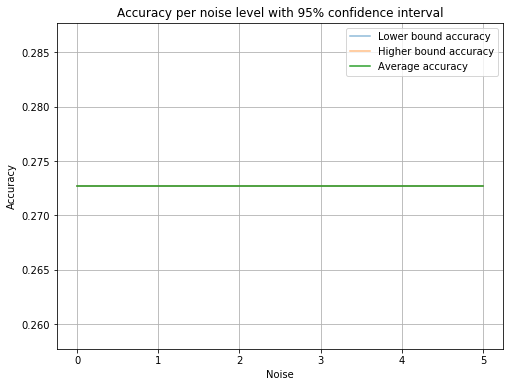

In [48]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### top 1 Xbox correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

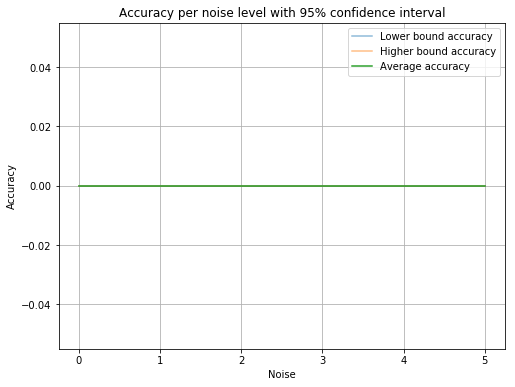

In [49]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_xbox, big_hit_per_year_xbox, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 3 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

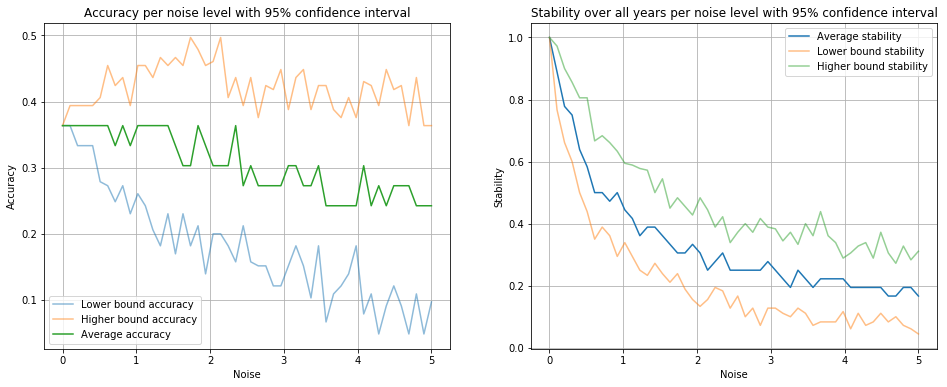

In [32]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

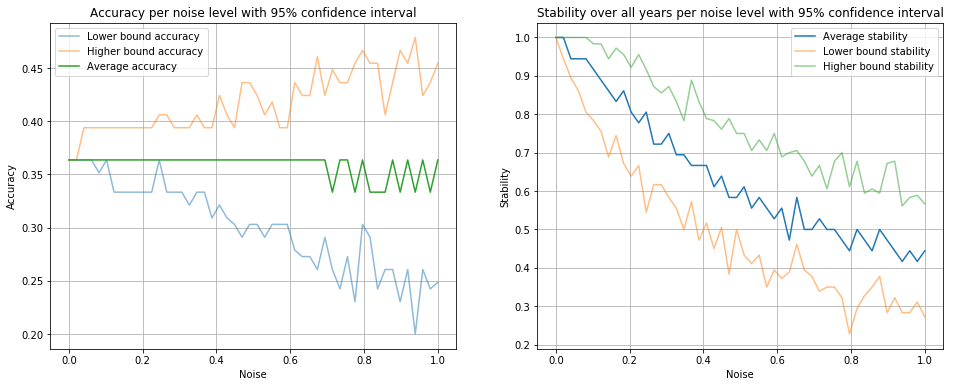

In [79]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.show()

#### Top 2 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of tthe previous 4 years

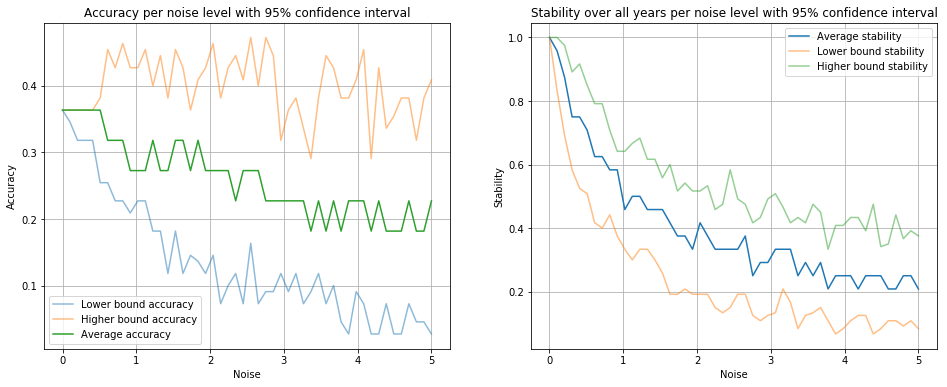

In [52]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

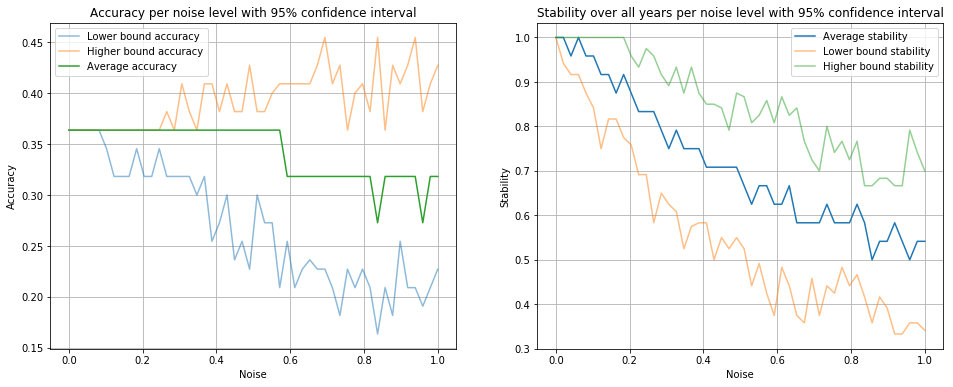

In [80]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.show()

#### Top 1 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of tthe previous 4 years

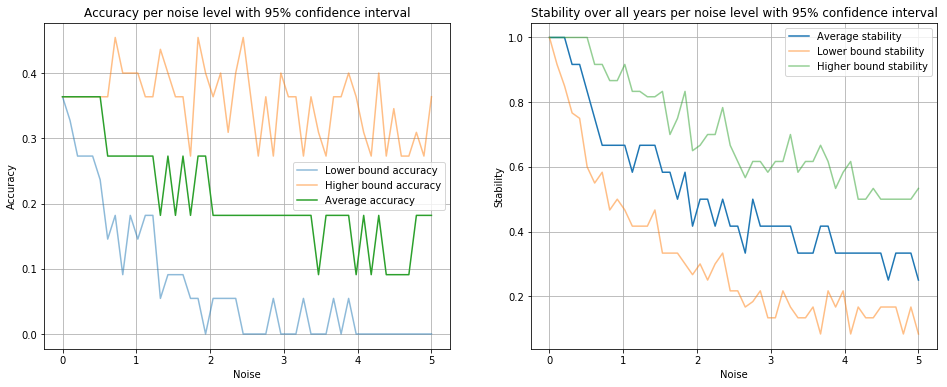

In [53]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

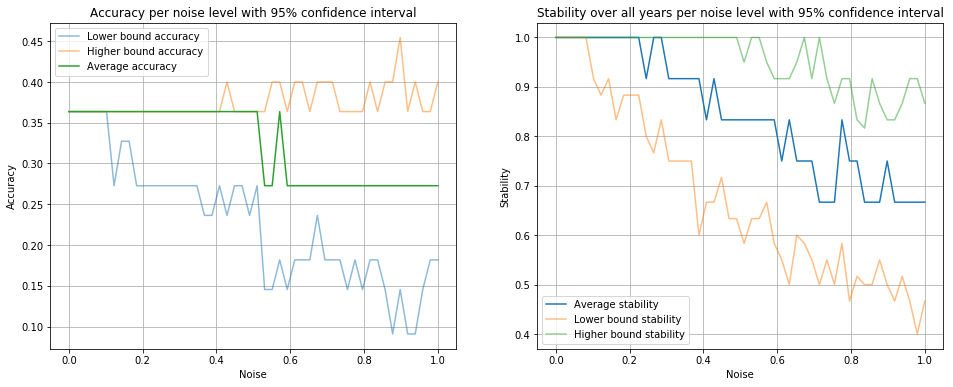

In [81]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 2)
plt.show()

#### Top 3 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of tthe previous 4 years

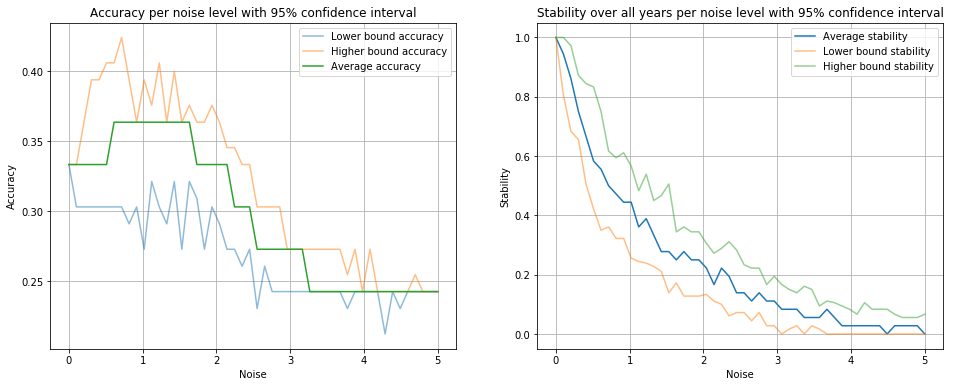

In [33]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

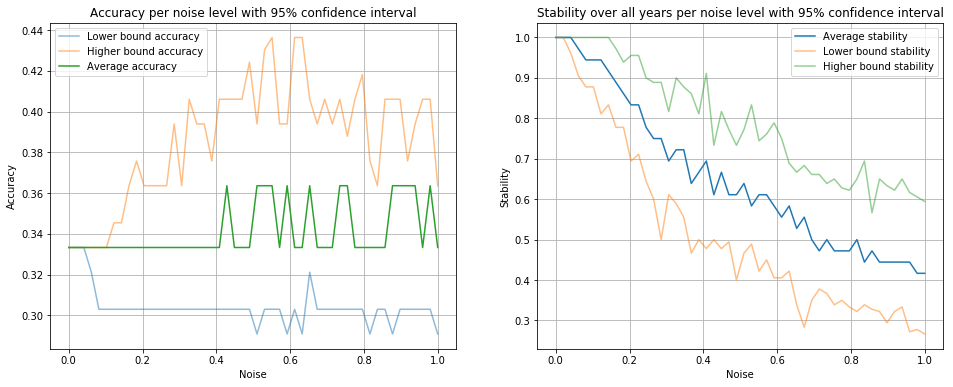

In [82]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.show()

#### Top 2 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of tthe previous 4 years

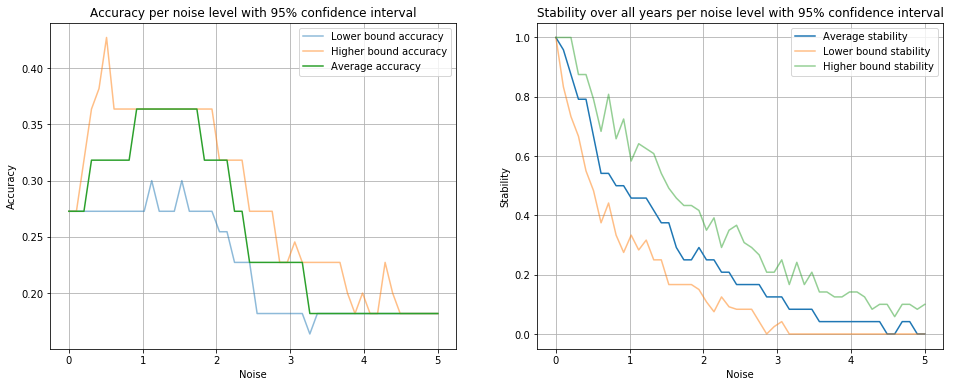

In [54]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

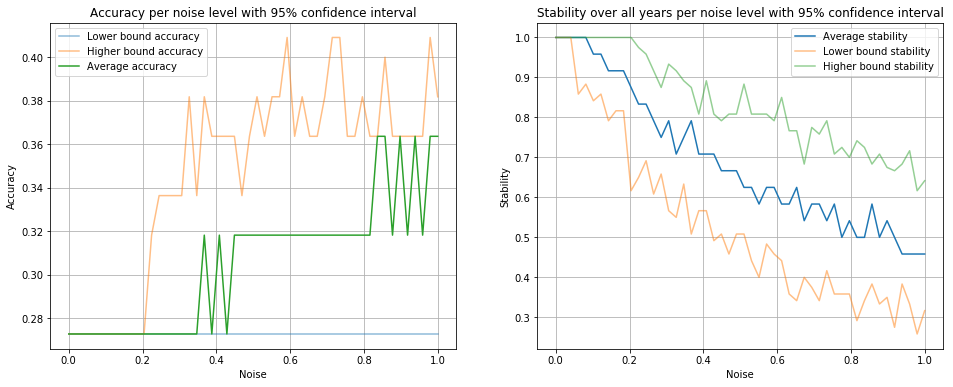

In [83]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.show()

#### Top 1 PlayStation Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

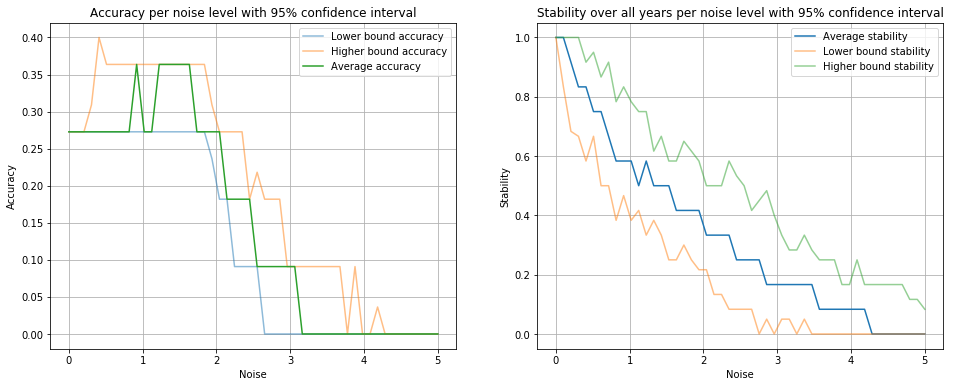

In [55]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

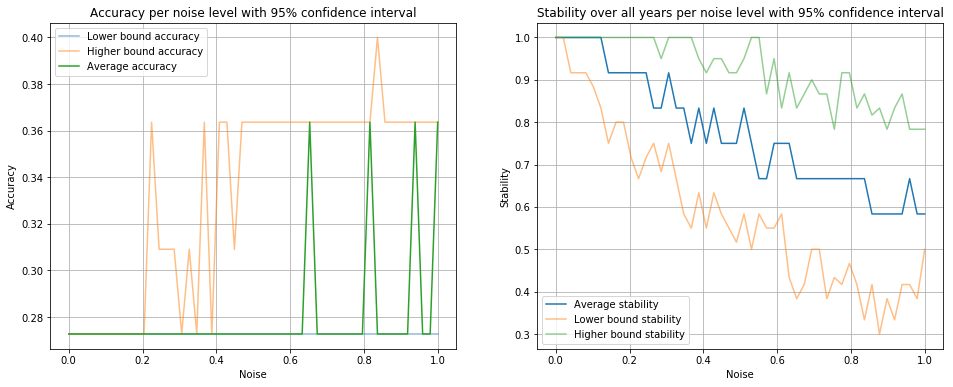

In [84]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_playstation, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max1, noise_steps, times, 1)
plt.show()

#### Top 3 PlayStation correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

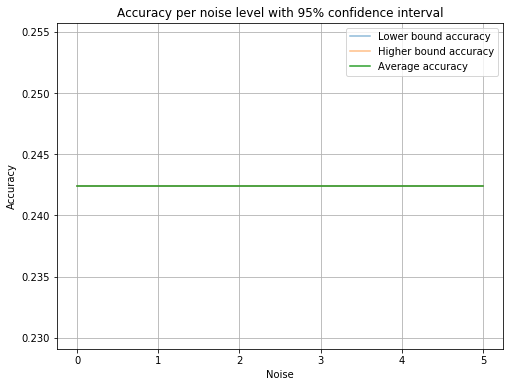

In [34]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 2 PlayStation correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

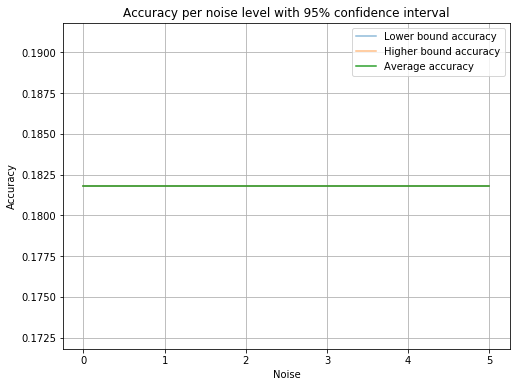

In [56]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 1 PlayStation correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

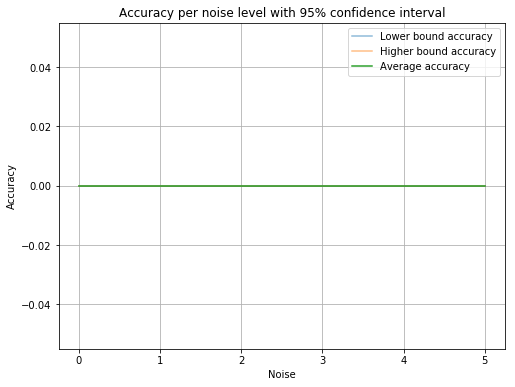

In [57]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_playstation, big_hit_per_year_playstation, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 3 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of tthe previous 4 years

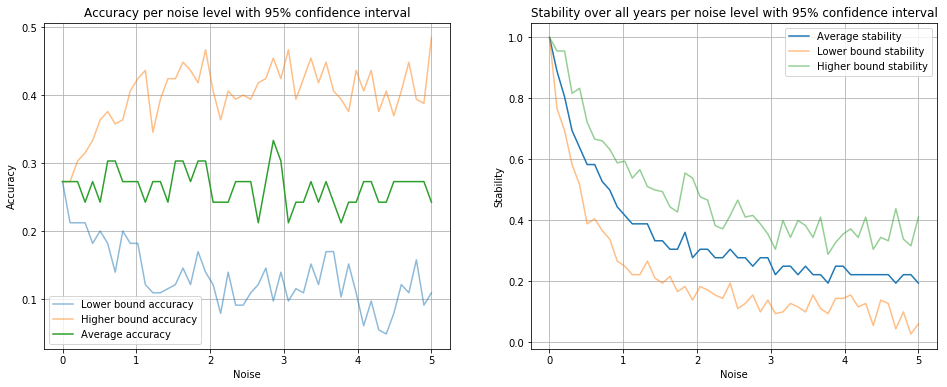

In [35]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 2 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

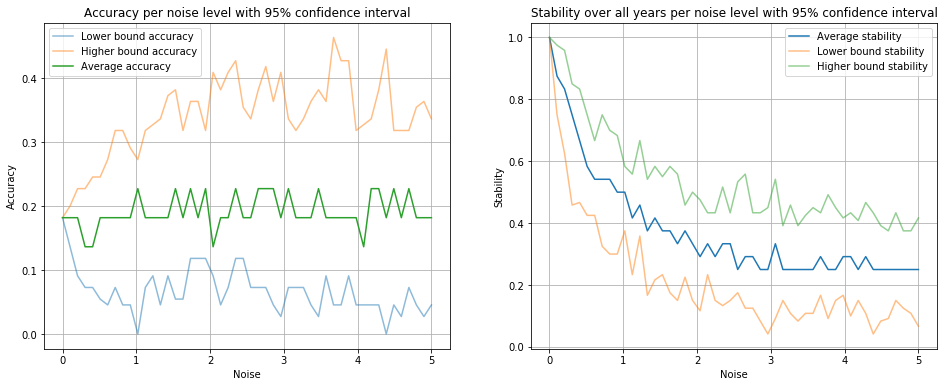

In [58]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 1 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

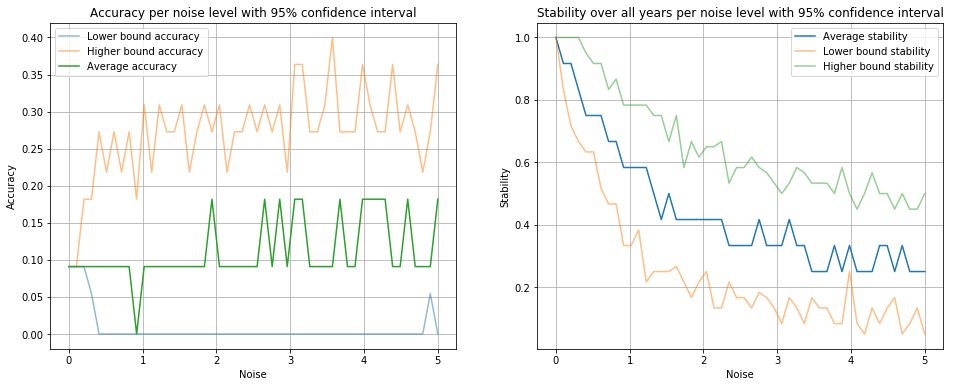

In [59]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 3 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

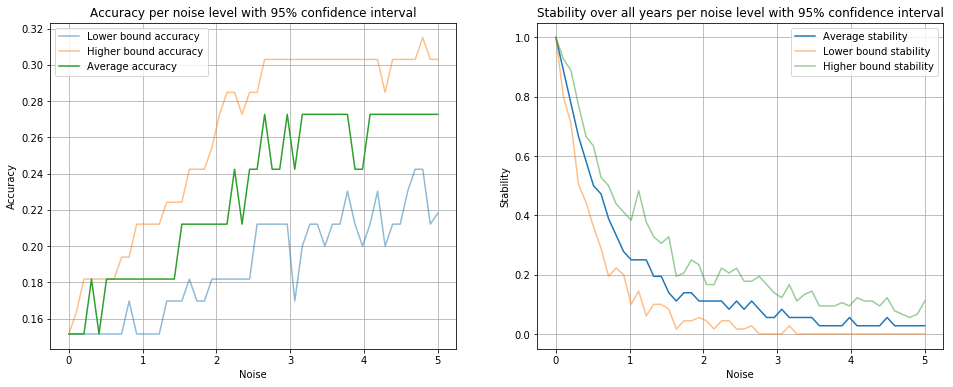

In [36]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 2 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

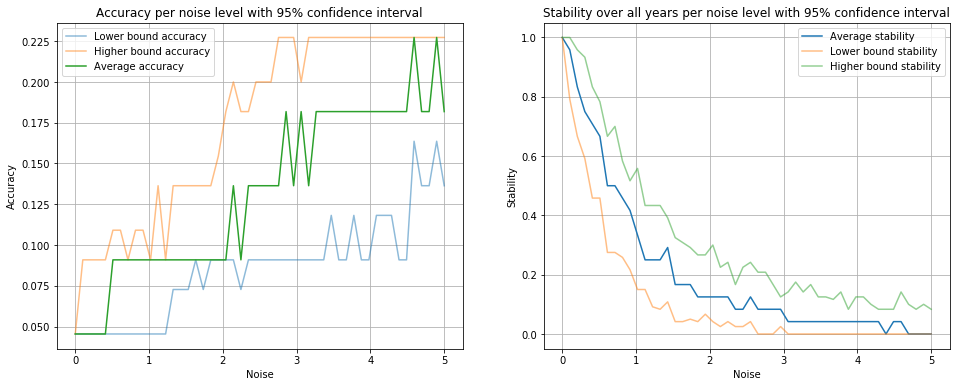

In [60]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 1 Nintendo Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

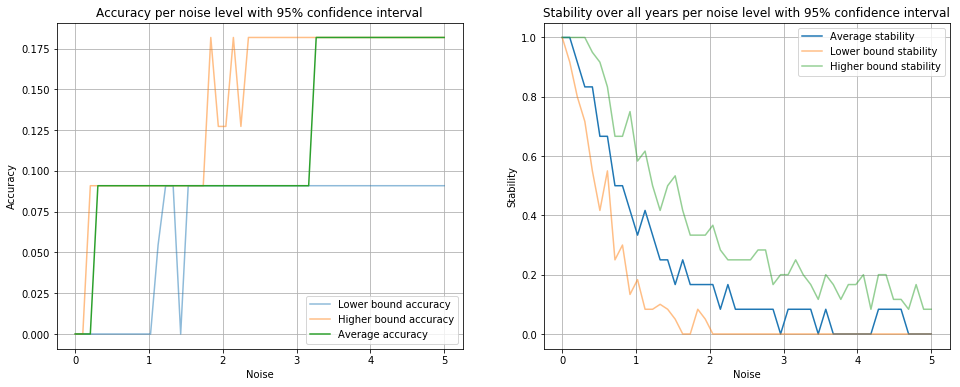

In [61]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_nintendo, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 3 Nintendo correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

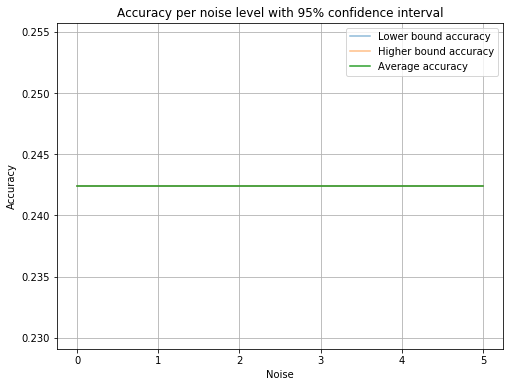

In [37]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 2 Nintendo correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

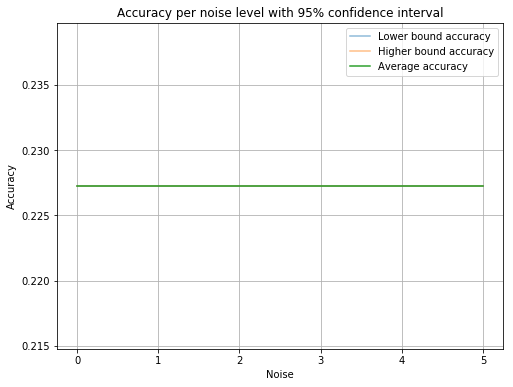

In [62]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 1 Nintendo correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

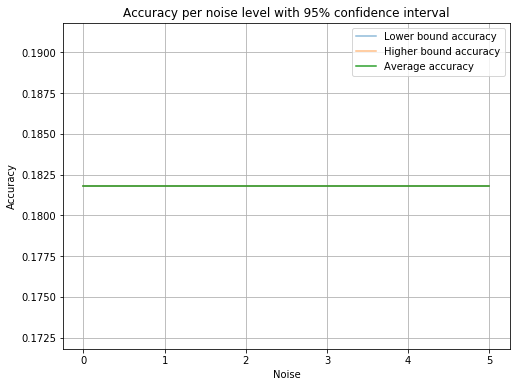

In [63]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_nintendo, big_hit_per_year_nintendo, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 3 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

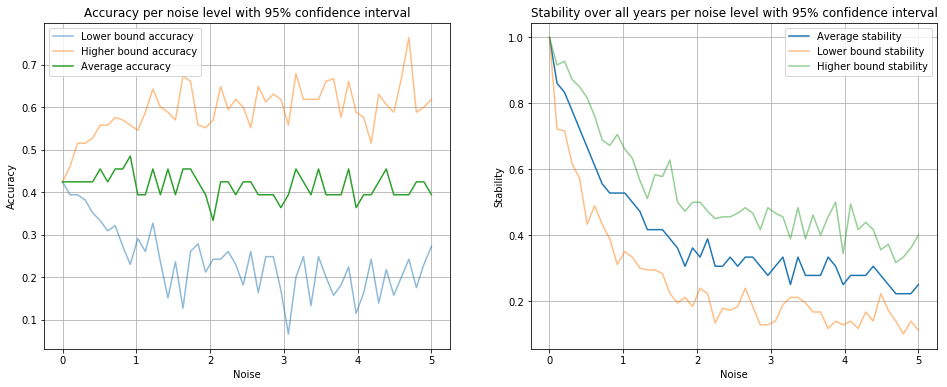

In [38]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 2 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

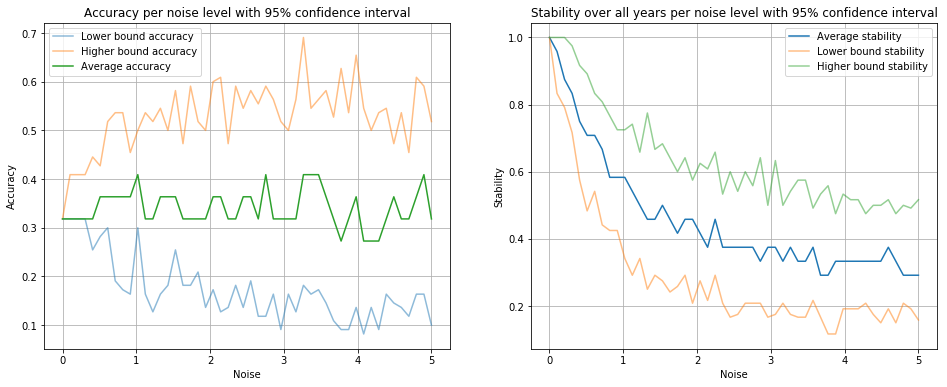

In [64]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 1 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

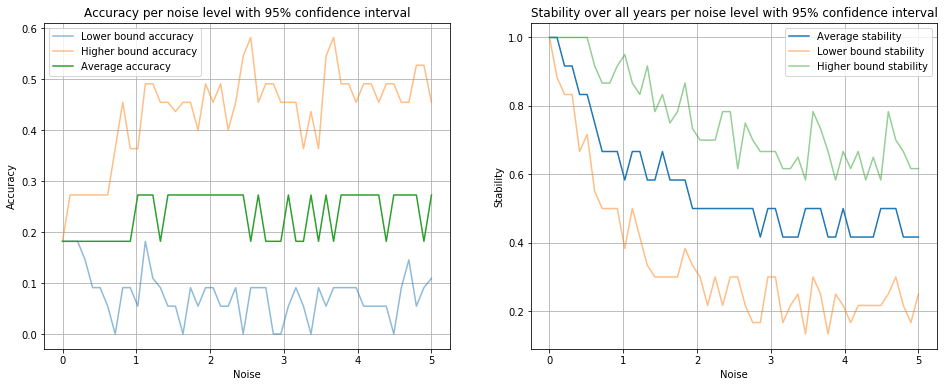

In [65]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 3 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

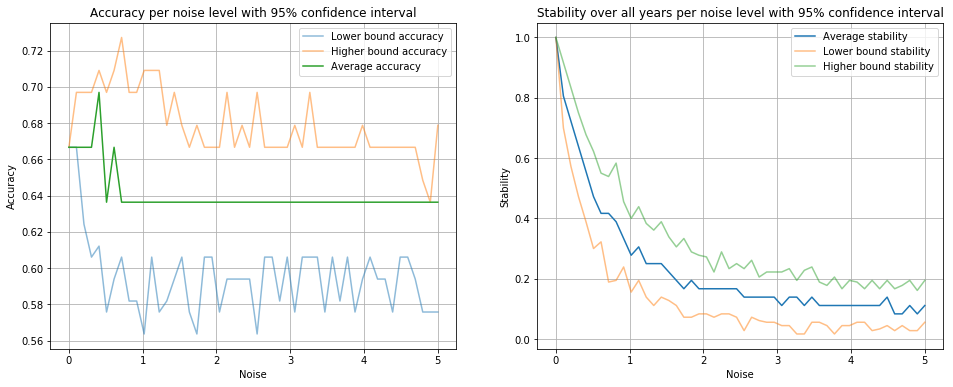

In [39]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 2 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

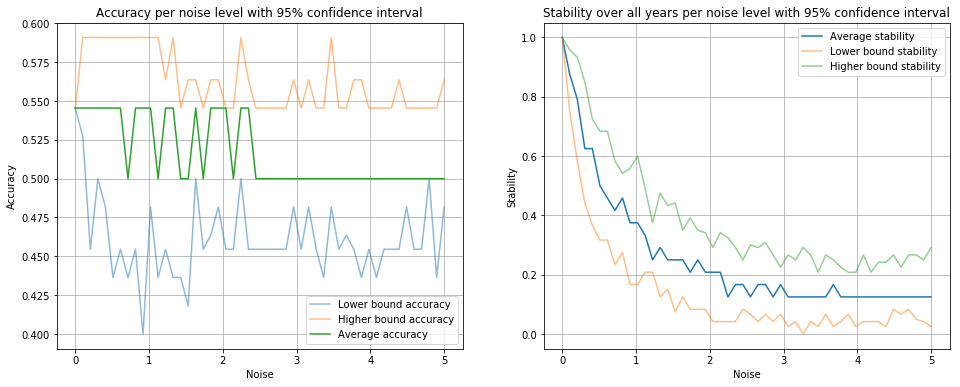

In [66]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 1 PC Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

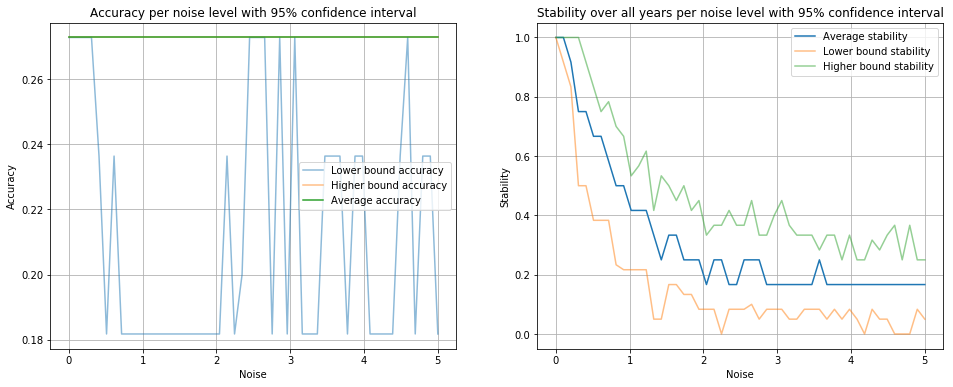

In [67]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data_pc, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 3 PC correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

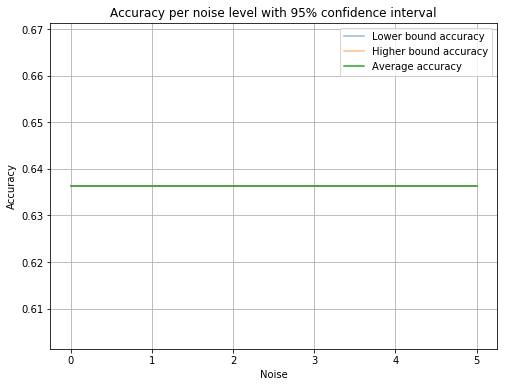

In [40]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 2 PC correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

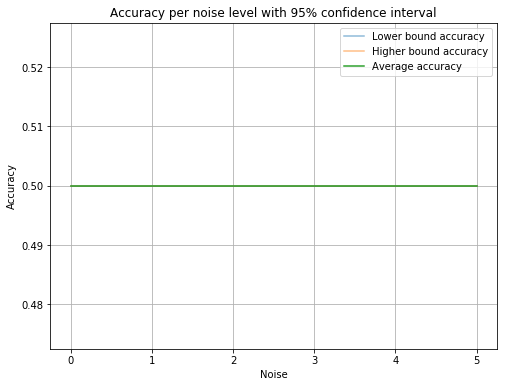

In [68]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 1 PC correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

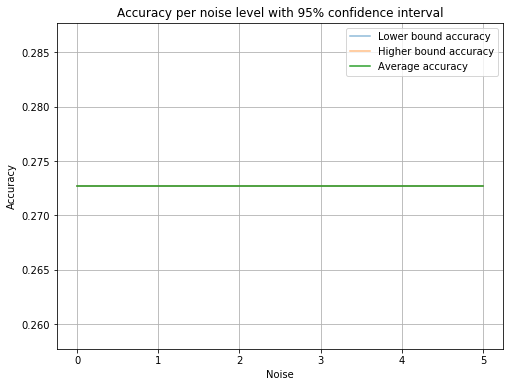

In [69]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data_pc, big_hit_per_year_pc, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 3 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

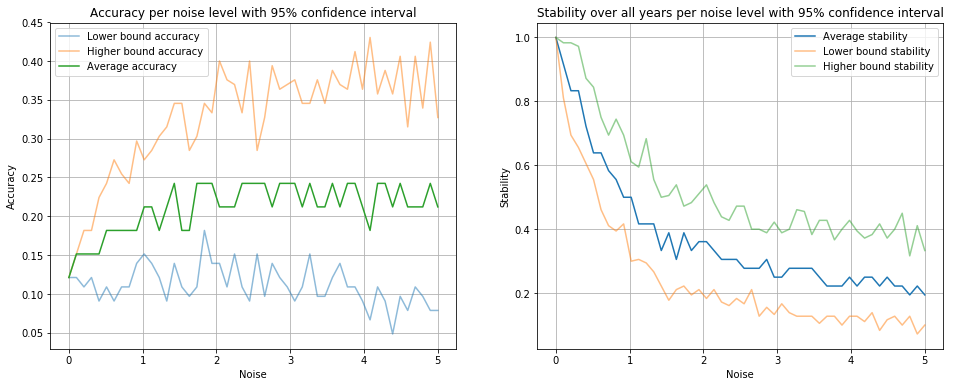

In [41]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 2 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

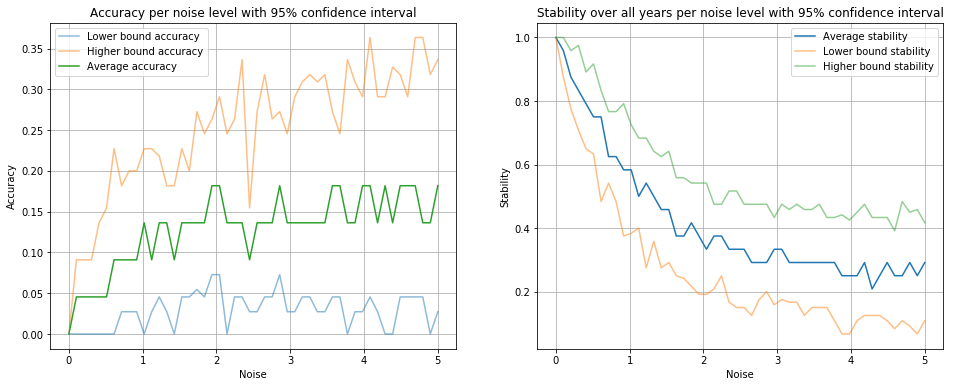

In [70]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 1 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1$  using data of the previous 4 years

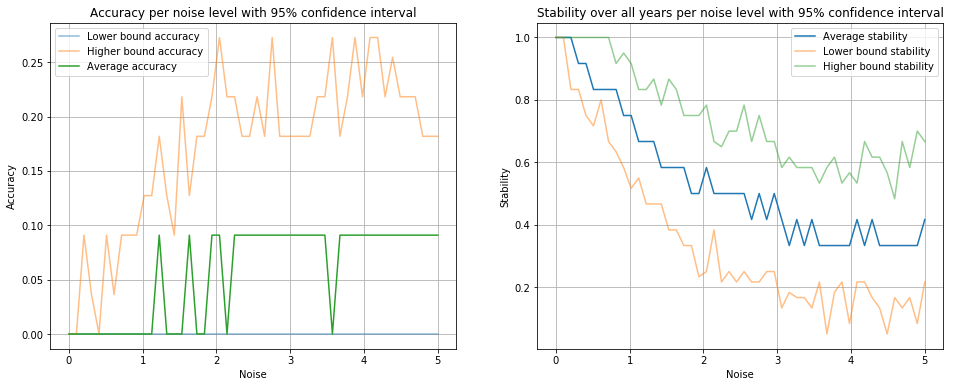

In [71]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 2)
plt.show()

#### Top 3 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

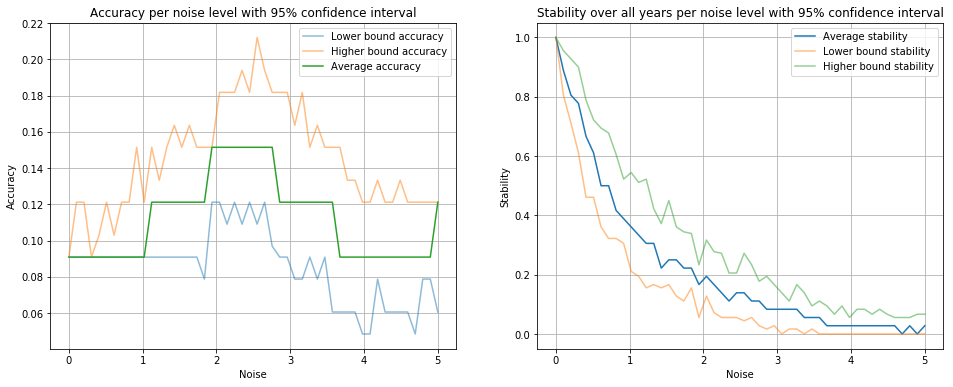

In [72]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 2 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

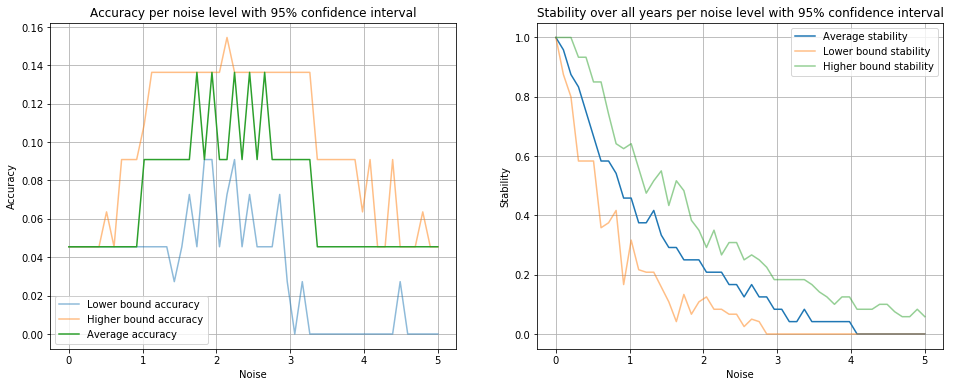

In [73]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size1,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 1 All consoles Accuracy-/Stability-Test for LRM $Sales = score*X_0 + genre*X_1 + genre*score*X_2$  using data of the previous 4 years

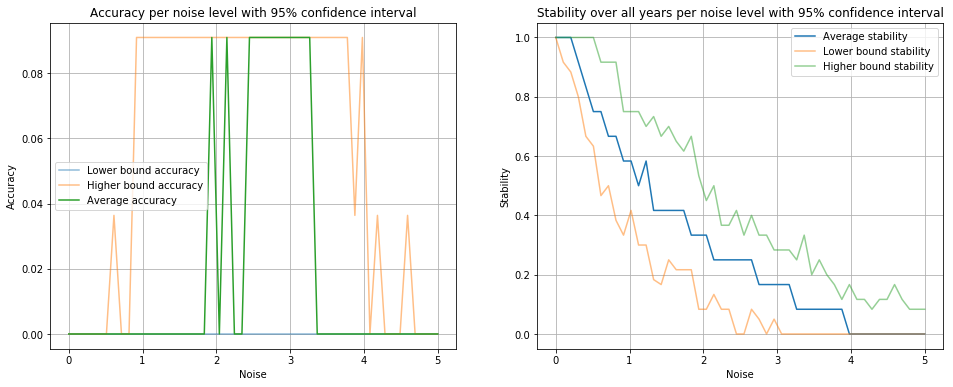

In [74]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.subplot(1, 2, 2)
plt.grid(True)
plot_stability_per_noise(data, top_size2,
                        key_score, year_min, year_max, noise_min, noise_max, noise_steps, times, 1)
plt.show()

#### Top 3 All consoles correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

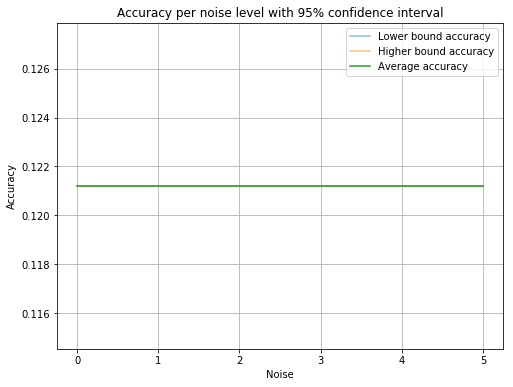

In [43]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 2 All consoles correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

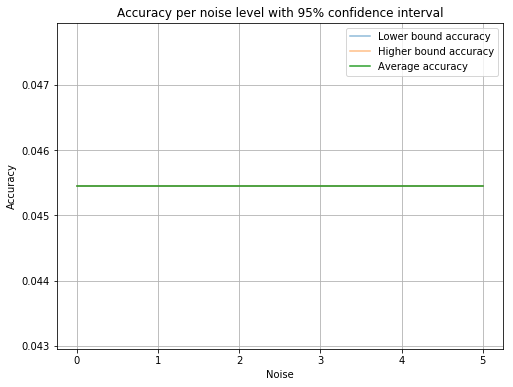

In [75]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size1,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()

#### Top 1 All consoles correctness accuracy for $Sales = genre * X_0$ using data up to 4 years back for each year

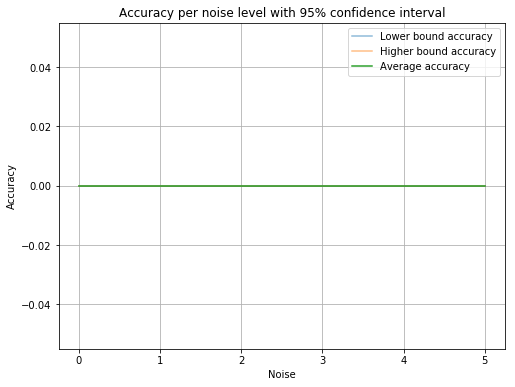

In [76]:
fig = plt.figure(figsize=(8, 6))
plt.grid(True)
plot_accuracy_per_noise(data, big_hit_per_year, top_size2,\
                        key_score, year_min, year_max, noise_min, noise_max, 2, 1, 0)
plt.show()